<a href="https://colab.research.google.com/github/Olena299/Python-Projects/blob/main/Portfolio_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###1. Підключення даних до SQL

In [ ]:
from google.colab import auth
from google.cloud import bigquery
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

In [ ]:
auth.authenticate_user()


In [ ]:
client = bigquery.Client(project="data-analytics-mate")


In [ ]:
query = """
SELECT
  ss.date AS order_date,
  ss.ga_session_id AS session_id,
  sp.continent AS continent,
  sp.country AS country,
  sp.device,
  sp.browser,
  sp.channel,
  sp.operating_system,
  sp.language AS browser_language,
  sp.medium AS source_of_info,
  sp.name AS name_of_source,
  acs.account_id AS registrated_id,
  ac.is_verified AS verified_id,
  ac.is_unsubscribed AS unsubscribed_id,
  pr.category AS product_category,
  pr.name AS product_name,
  pr.price AS product_price,
  pr.short_description AS product_description
FROM
  `DA.session` ss
LEFT JOIN
  `DA.account_session`acs
ON
  ss.ga_session_id = acs.ga_session_id
LEFT JOIN
  `DA.session_params`sp
ON
  ss.ga_session_id = sp.ga_session_id
LEFT JOIN
  `DA.account`ac
ON
  acs.account_id = ac.id
LEFT JOIN
  `DA.order`o
ON
  ss.ga_session_id = o.ga_session_id
LEFT JOIN
  `DA.product`pr
ON
  o.item_id = pr.item_id
GROUP BY
  ss.date,
  ss.ga_session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.channel,
  sp.operating_system,
  sp.language,
  sp.medium,
  sp.name,
  acs.account_id,
  ac.is_verified,
  ac.is_unsubscribed,
  pr.category,
  pr.name,
  pr.price,
  pr.short_description
"""


In [ ]:
query_job = client.query(query)
results = query_job.result()


In [ ]:
df = results.to_dataframe()


###2. Data overview. Розуміння даних та їх змісту. Очищення даних та заповнення пропущених значень. Опис датафрейму.

In [ ]:
df.head()


,order_date,session_id,continent,country,device,browser,channel,operating_system,browser_language,source_of_info,name_of_source,registrated_id,verified_id,unsubscribed_id,product_category,product_name,product_price,product_description
0,2020-11-01,6424219101,Asia,Japan,desktop,Chrome,Organic Search,Windows,None,cpc,<Other>,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,1353274412,Americas,United States,desktop,Safari,Organic Search,Macintosh,en-gb,cpc,<Other>,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,6865736891,Europe,Czechia,mobile,Safari,Organic Search,Web,en-gb,cpc,<Other>,<NA>,<NA>,<NA>,Bar furniture,FRANKLIN,149.0,"Bar stool with backrest, foldable, 74 cm"
3,2020-11-01,1096922315,Asia,Taiwan,desktop,Chrome,Organic Search,Web,en-us,cpc,<Other>,<NA>,<NA>,<NA>,None,None,NaN,None
4,2020-11-01,6642187874,Americas,United States,desktop,Chrome,Organic Search,Windows,zh,cpc,<Other>,<NA>,<NA>,<NA>,None,None,NaN,None


In [ ]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_date           349545 non-null  dbdate 
 1   session_id           349545 non-null  Int64  
 2   continent            349545 non-null  object 
 3   country              349545 non-null  object 
 4   device               349545 non-null  object 
 5   browser              349545 non-null  object 
 6   channel              349545 non-null  object 
 7   operating_system     349545 non-null  object 
 8   browser_language     235279 non-null  object 
 9   source_of_info       349545 non-null  object 
 10  name_of_source       349545 non-null  object 
 11  registrated_id       27945 non-null   Int64  
 12  verified_id          27945 non-null   Int64  
 13  unsubscribed_id      27945 non-null   Int64  
 14  product_category     33538 non-null   object 
 15  product_name     

 В датафреймі 349545 рядків та 18 стовпчиков

In [ ]:
print(df.shape)

(349545, 18)


В датафреймі є пропущені значення в 8-х стовпчиках: browser_language:     114266, registrated_id: 321600, verified_id: 321600, unsubscribed_id: 321600, product_category: 316007, product_name: 316007, product_price: 316007, product_description: 316007. Ці пропущені значення є тому, що ми беремо усі сесії, які відбулись на сайті, у тому числі від незареєстрованих користувачів.  Ці користувачі не є зареєстрованими, тобто також немає даних про їх підписку та верифікацію. Також під час цих сесій могло не відбутися покупки товару і в товару немає значень, таких як назва, категорія, ціна и т.п.

In [ ]:
print(df.isna().sum())

order_date                  0
session_id                  0
continent                   0
country                     0
device                      0
browser                     0
channel                     0
operating_system            0
browser_language       114266
source_of_info              0
name_of_source              0
registrated_id         321600
verified_id            321600
unsubscribed_id        321600
product_category       316007
product_name           316007
product_price          316007
product_description    316007
dtype: int64


In [ ]:
print(df.isna().sum() / df.shape[0] * 100)

order_date              0.000000
session_id              0.000000
continent               0.000000
country                 0.000000
device                  0.000000
browser                 0.000000
channel                 0.000000
operating_system        0.000000
browser_language       32.689925
source_of_info          0.000000
name_of_source          0.000000
registrated_id         92.005321
verified_id            92.005321
unsubscribed_id        92.005321
product_category       90.405241
product_name           90.405241
product_price          90.405241
product_description    90.405241
dtype: float64


Оскільки доля пропусків по усім стовпчикам з пропущеними значеннями більше 6 відсотків, не можна просто видалити ці дані. Заповнюємо пропущенні значення у стовпчиках з категоріальними даними значенням "Unknown". Оскільки доля пропусків з кількісними даними достатньо велика, не можна просто видалити ці дані. Але не можна просто проставити 0, бо таке значення має пояснення. Створюємо копію з заповненними значеннями, щоб можна було повернутися до початку аналіза, якщо щось піде не так. Дивимися, чи лишились пропущені дані. Вони лишились у 4-х стовпчиках. Для аналізу даних по продажам та зареєстрованим користувачам создамо окремі датафрейми.Для загального аналізу будем працювати з df_filled.


In [ ]:
df_filled = df.copy()
df_filled["browser_language"] = df_filled["browser_language"].fillna("Unknown")
df_filled["product_category"] = df_filled["product_category"].fillna("Unknown")
df_filled["product_name"] = df_filled["product_name"].fillna("Unknown")
df_filled["product_description"] = df_filled["product_description"].fillna("Unknown")

print(df_filled.isna().sum())
print(df_filled.head())

order_date                  0
session_id                  0
continent                   0
country                     0
device                      0
browser                     0
channel                     0
operating_system            0
browser_language            0
source_of_info              0
name_of_source              0
registrated_id         321600
verified_id            321600
unsubscribed_id        321600
product_category            0
product_name                0
product_price          316007
product_description         0
dtype: int64
   order_date  session_id continent        country   device browser  \
0  2020-11-01  6424219101      Asia          Japan  desktop  Chrome   
1  2020-11-01  1353274412  Americas  United States  desktop  Safari   
2  2020-11-01  6865736891    Europe        Czechia   mobile  Safari   
3  2020-11-01  1096922315      Asia         Taiwan  desktop  Chrome   
4  2020-11-01  6642187874  Americas  United States  desktop  Chrome   

          channel op

Зміна типів даних для дати

In [ ]:
df_filled["order_date"] = pd.to_datetime(df_filled["order_date"], format="%Y/%m/%d")
print(df_filled.dtypes)

order_date             datetime64[ns]
session_id                      Int64
continent                      object
country                        object
device                         object
browser                        object
channel                        object
operating_system               object
browser_language               object
source_of_info                 object
name_of_source                 object
registrated_id                  Int64
verified_id                     Int64
unsubscribed_id                 Int64
product_category               object
product_name                   object
product_price                 float64
product_description            object
dtype: object


Перевірка на дублікати

In [ ]:
duplicate_rows = df_filled.duplicated()
print(duplicate_rows)
print(duplicate_rows.sum())

0         False
1         False
2         False
3         False
4         False
          ...  
349540    False
349541    False
349542    False
349543    False
349544    False
Length: 349545, dtype: bool
0


Для product_price створюємо окремий датафрейм df_orders, тому що не можна заповнювати дані "0" - це спотворить результати, а видалити ці рядки також не можна. Тобто, там, те потрібно працювати з продажами, працюєм з df_orders. Для загальних даних будем використовувати df_filled.

In [ ]:
df_orders = df_filled.copy()
df_orders = df_filled.dropna(subset=['product_price'])

In [ ]:
df_orders.describe()

,order_date,session_id,registrated_id,verified_id,unsubscribed_id,product_price
count,33538,33538.0,2781.0,2781.0,2781.0,33538.000000
mean,2020-12-14 15:09:05.506589440,4964900683.146312,658815.525351,0.71521,0.160734,953.298679
min,2020-11-01 00:00:00,330355.0,636138.0,0.0,0.0,3.000000
25%,2020-11-25 00:00:00,2476893918.0,647432.0,0.0,0.0,170.000000
50%,2020-12-13 00:00:00,4961245290.0,658322.0,1.0,0.0,445.000000
75%,2021-01-06 00:00:00,7442296865.75,670218.0,1.0,0.0,1195.000000
max,2021-01-27 00:00:00,9999754183.0,681955.0,1.0,1.0,9585.000000
std,NaN,2884281407.544152,13140.190977,0.451395,0.367351,1317.001775


Для аналізу даних, які стосуються зареєстрованих користувачів, створюємо окремий датафрейм df_registration, тому що не можна заповнювати дані "0" або "1" - це спотворить результати, а видалити ці рядки також не можна. Тобто, там, те потрібно працювати з даними, які стосуються зареєстрованих користувачів, працюєм з df_registration. Для загальних даних будем використовувати df_filled.

In [ ]:
df_registration = df_filled.copy()
df_registration = df_filled.dropna(subset=['registrated_id'])
df_registration = df_filled.dropna(subset=['verified_id'])
df_registration = df_filled.dropna(subset=['unsubscribed_id'])

Перевірка Data cleaning завершена, усі проблеми виявлені та виправлені.

Набір даних "df_filled" містить інформацію про усі сесії в період з 2020-11-01 по 2021-01-31.
+ order_date - дата замовлення;
+ session_id - ідентифікатор сесії;
+ continent - континент;
+ country - країна;
+ device  - девайс;
+ browser  - браузер;
+ channel - канал трафіку;
+ operating_system - операційна система;
+ browser_language - мова браузера;
+ source_of_info - інформація про джерело трафіку;
+ name_of_source - назва моделі пристрою;
+ registrated_id - ідентифікатор зареєстрованого користувача;
+ verified_id - чи підтвердив користувач свій email;
+ unsubscribed_id - чи підписався користувач на розсилку;
+ product_category - категорія товару;
+ product_name  - назва товару;
+ product_price — ціна за одиницю товару;
+ product_description - короткий опис товару;





В датафреймі 349545 рядків та 18 стовпчиков.
+ кількість колонок числового типу: 5 (session_id, registrated_id,
 verified_id та unsubscribed_id - Int64, product_price -                Float64)
+ кількість колонок категоріального типу: 12 (continent, country, device, browser, channel, operating_system, browser_language, source_of_info, name_of_source, product_category, product_name та  product_description)
+ кількість колонок типу datetime: 1 (order_date)


In [ ]:
print(df_filled.dtypes)

order_date             datetime64[ns]
session_id                      Int64
continent                      object
country                        object
device                         object
browser                        object
channel                        object
operating_system               object
browser_language               object
source_of_info                 object
name_of_source                 object
registrated_id                  Int64
verified_id                     Int64
unsubscribed_id                 Int64
product_category               object
product_name                   object
product_price                 float64
product_description            object
dtype: object


кількість унікальних сесій: 349545

In [ ]:
df_filled['session_id'].nunique()

349545

кількість сесій, коли відбулися покупки: 33538

In [ ]:
df_orders['session_id'].nunique()

33538

Кількість сесій з зареєстрованими користувачами: 27945

In [ ]:
df_registration['session_id'].nunique()

27945

Робота з описом датафрейму завершена

###3. Загальні показники компанії

Аналіз продажів виконується на df_orders: Усі розрахунки, пов'язані з продажами (сума, середнє, топ-категорії за продажами), виконуються на df_orders.

+ Компанія має найбільші продажі на континентах (топ-3): Americas, Asia,
Europe.
+ Компанія має найбільші продажі в країнах (топ-5): United States, India, Canada, United Kingdom, France.
+ Найбільшу кількість замовлень компанія має на континентах (топ-3): Americas, Asia,
Europe.
+ Найбільшу кількість замовлень компанія має в країнах (топ-5): United States, India, Canada, United Kingdom, France.
+ Топ-10 категорій товарів за загальною сумою продажів: Sofas & armchairs, Chairs, Beds , Bookcases & shelving units, Cabinets & cupboards, Outdoor furniture, Tables & desks, Chests of drawers & drawer units, Bar furniture, Children's furniture.
+ Топ-10 категорій товарів у країні з найбільшими продажами (United States): Sofas & armchairs, Chairs, Beds, Bookcases & shelving units, Cabinets & cupboards, Outdoor furniture, Tables & desks, Chests of drawers & drawer units, Bar furniture, Children's furniture.
+ Ситуація не відрізняється від загальної, у топі ті ж категорії, що у загальному, що по країні з найбільшими продажами.

In [ ]:
top_continents_by_sales = df_orders.groupby('continent')['product_price'].sum().nlargest(3)
print("\nTop-3 continents by sales:\n", top_continents_by_sales)

top_countries_by_sales = df_orders.groupby('country')['product_price'].sum().nlargest(5)
print("\nTop-5 countries by sales:\n", top_countries_by_sales)

top_continents_by_orders = df_orders.groupby('continent').size().nlargest(3)
print("\nTop-3 continents by orders\n", top_continents_by_orders)

top_countries_by_orders = df_orders.groupby('country').size().nlargest(5)
print("\nTop-5 countrшуі by orders\n", top_countries_by_orders)

top_categories_sales = df_orders.groupby('product_category')['product_price'].sum().nlargest(10)
print("\nTop-10 product categories by sales\n", top_categories_sales)

most_sales_country = top_countries_by_sales.index[0]
top_categories_in_country = df_orders[df_orders['country'] == most_sales_country].groupby('product_category')['product_price'].sum().nlargest(10)
print(f"\nTop categories in country {most_sales_country} by sales:\n", top_categories_in_country)


print("\nComparing with general top by countries:")
print(pd.concat([top_categories_sales, top_categories_in_country], axis=1, keys=['General top', f'Top by {most_sales_country}']))


Top-3 continents by sales:
 continent
Americas    17665280.0
Asia         7601298.3
Europe       5934624.2
Name: product_price, dtype: float64

Top-5 countries by sales:
 country
United States     13943553.9
India              2809762.0
Canada             2437921.0
United Kingdom      938317.9
France              710692.8
Name: product_price, dtype: float64

Top-3 continents by orders
 continent
Americas    18553
Asia         7950
Europe       6261
dtype: int64

Top-5 countrшуі by orders
 country
United States     14673
India              3029
Canada             2560
United Kingdom     1029
France              678
dtype: int64

Top-10 product categories by sales
 product_category
Sofas & armchairs                   8388254.5
Chairs                              6147748.8
Beds                                4919725.0
Bookcases & shelving units          3640818.1
Cabinets & cupboards                2336499.5
Outdoor furniture                   2142222.2
Tables & desks                    

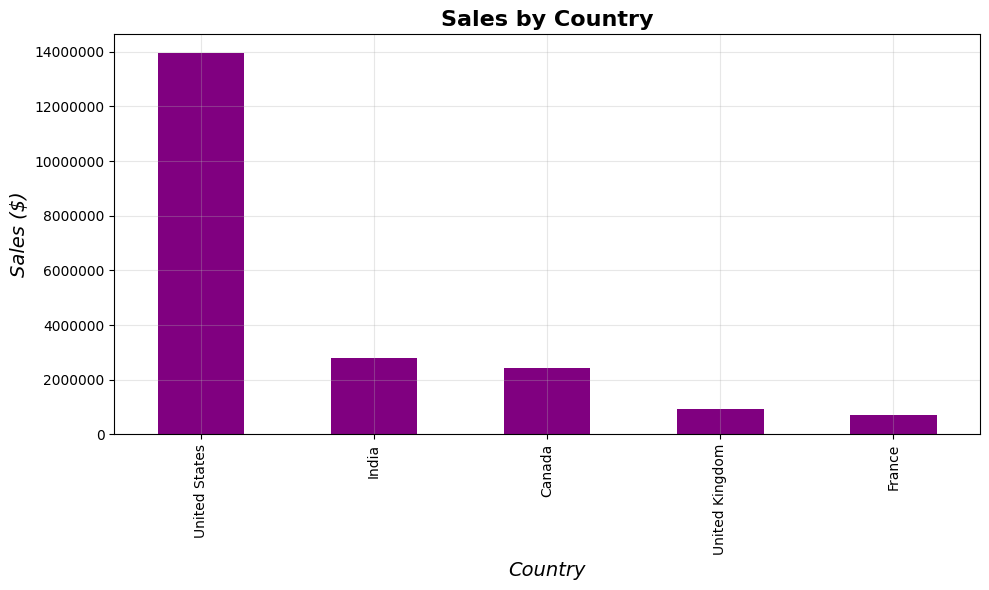

In [ ]:
plt.figure(figsize=(10, 6))
top_countries_by_sales.plot(kind='bar', color='purple')
plt.title("Sales by Country", fontsize=16, fontweight="bold")
plt.xlabel("Country", fontsize=14, fontstyle="italic")
plt.ylabel("Sales ($)", fontsize=14, fontstyle="italic")
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

+ Продажі у розрізі типів та моделей девайсів (у % від загальних продажів): desktop: 59%, mobile: 38%, tablet: 2%.
+ Продажі за каналами трафіку (у % від загальних продажів): data deleted: 6%, direct: 23%, organic: 34%, referral: 17%, Other: 18%.
+ Продажі за джерелами трафіку (у % від загальних продажів): data deleted: 6%, none: 23%, Other: 14%, cpc: 4%, organic: 34%, referral: 17%.

In [ ]:
total_sales = df_orders['product_price'].sum()

device_sales = df_orders.groupby('device')['product_price'].sum()
device_sales_percent = (device_sales / total_sales) * 100
print("\nDevices sales( %):\n", device_sales_percent)

model_sales = df_orders.groupby('name_of_source')['product_price'].sum()
model_sales_percent = (model_sales / total_sales) * 100
print("\nSources sales(%):\n", model_sales_percent)


source_sales = df_orders.groupby('source_of_info')['product_price'].sum()
source_sales_percent = (source_sales / total_sales) * 100
print("\nSales by sources (у %):\n", source_sales_percent)


Devices sales( %):
 device
desktop    59.002245
mobile     38.734924
tablet      2.262831
Name: product_price, dtype: float64

Sources sales(%):
 name_of_source
(data deleted)     6.262836
(direct)          23.442345
(organic)         34.202840
(referral)        17.646386
<Other>           18.445594
Name: product_price, dtype: float64

Sales by sources (у %):
 source_of_info
(data deleted)     6.386645
(none)            23.442345
<Other>           14.047882
cpc                4.273902
organic           34.202840
referral          17.646386
Name: product_price, dtype: float64


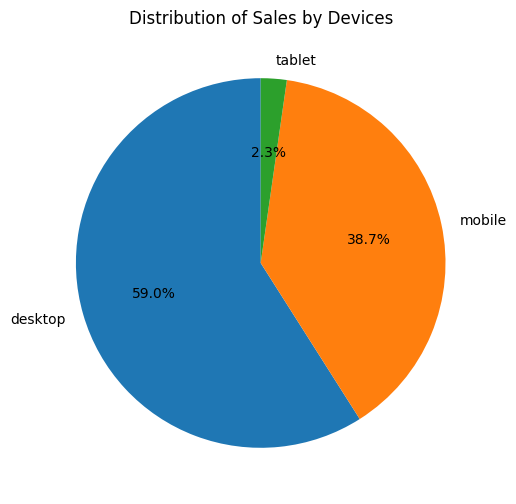

In [ ]:
plt.figure(figsize=(8, 6))
plt.pie(device_sales_percent, labels=device_sales_percent.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sales by Devices')
plt.show()

+ відсоток зареєстрованих користувачів, що підтвердив свою електронну адресу: 71%
+ відсоток зареєстрованих користувачів, який відписався від розсилки: 17%


In [ ]:
total_registered = df_registration['registrated_id'].astype(bool).sum()
verified_count = df_registration[df_registration['verified_id'] == 1]['verified_id'].sum()
unsubscribed_count = df_registration[df_registration['unsubscribed_id'] == 1]['unsubscribed_id'].sum()

verified_percent = (verified_count / total_registered) * 100 if total_registered > 0 else 0
unsubscribed_percent = (unsubscribed_count / total_registered) * 100 if total_registered > 0 else 0

print(f"\n% of registered verified users: {verified_percent}%")
print(f"% of unsubscribed users: {unsubscribed_percent}%")


% of registered verified users: 71.69797817140812%
% of unsubscribed users: 16.94399713723385%


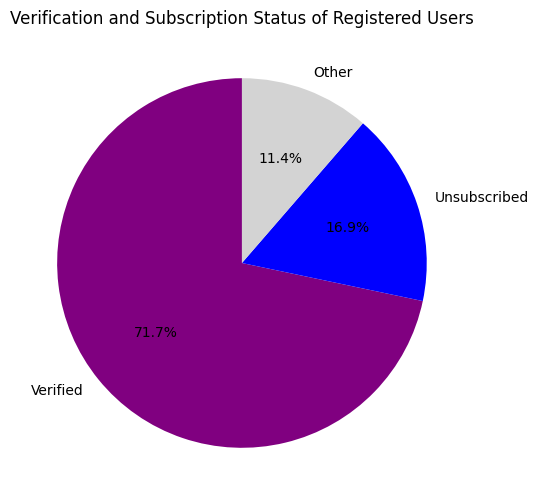

In [ ]:
labels = ['Verified', 'Unsubscribed', 'Other']
sizes = [verified_percent, unsubscribed_percent, 100 - verified_percent - unsubscribed_percent]
colors = ['purple', 'blue', 'lightgray']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Verification and Subscription Status of Registered Users')
plt.show()

Поведінка (у плані продажів) тих, хто відписався від розсилки та тих, хто досі підписаний відрізняється:
+ тих, хто відписався від розсилки: 16,7% від продажів,
+ тих, хто досі підписаний: 83,3% від продажів,
+ середній чек для тих, хто досі підписаний: 921,
+ середній чек для тих, хто відписався від розсилки: 965.

In [ ]:
subscribed_sales = df_orders[df_orders['unsubscribed_id'] == 0]['product_price'].sum()
unsubscribed_sales = df_orders[df_orders['unsubscribed_id'] == 1]['product_price'].sum()

total_sales_reg = df_orders[df_orders['registrated_id'] != 0]['product_price'].sum()

subscribed_percent = (subscribed_sales / total_sales_reg) * 100 if total_sales_reg > 0 else 0
unsubscribed_percent = (unsubscribed_sales / total_sales_reg) * 100 if total_sales_reg > 0 else 0


print(f"\n% of sales for subscribed users: {subscribed_percent}%")
print(f"% of sales for unsubscribed users: {unsubscribed_percent}%")

subscribed_avg_check = df_orders[df_orders['unsubscribed_id'] == 0]['product_price'].mean()
unsubscribed_avg_check = df_orders[df_orders['unsubscribed_id'] == 1]['product_price'].mean()

print(f"\nAverage sales from subscribed users: {subscribed_avg_check}")
print(f"Average sales from unsubscribed users: {unsubscribed_avg_check}")


% of sales for subscribed users: 83.28292323946566%
% of sales for unsubscribed users: 16.71707676053434%

Average sales from subscribed users: 921.5068123393315
Average sales from unsubscribed users: 965.8201342281878


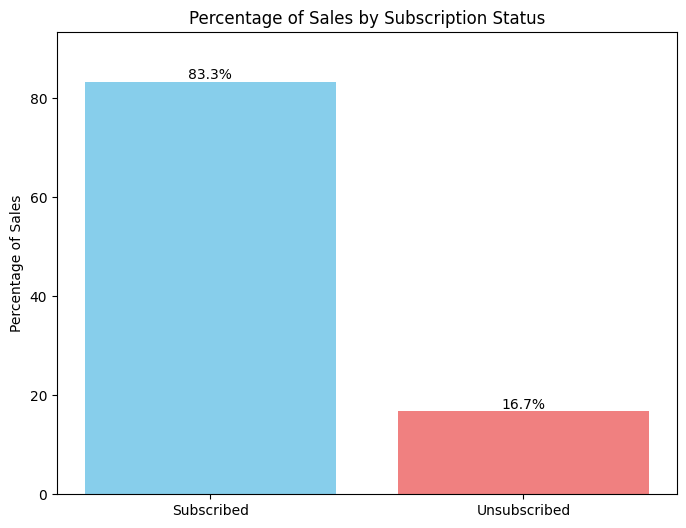

In [ ]:
labels = ['Subscribed', 'Unsubscribed']
sizes = [subscribed_percent, unsubscribed_percent]
colors = ['skyblue', 'lightcoral']

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, sizes, color=colors)

plt.ylabel('Percentage of Sales')
plt.title('Percentage of Sales by Subscription Status')
plt.ylim(0, max(sizes) + 10)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')

plt.show()


Найбільше зареєстрованих користувачів в країнах (топ-5): United States, India, Canada, United Kingdom, France.



In [ ]:
registered_users_by_country = df_registration[df_registration['registrated_id'] != 0]['country'].value_counts().nlargest(5)
print("\nTop 5 countries with registered users:\n", registered_users_by_country)


Top 5 countries with registered users:
 country
United States     12384
India              2687
Canada             2067
United Kingdom      859
France              553
Name: count, dtype: int64


###4. Аналіз динаміки продажів.

+ Загальні продажі за кожну дату, візуалізація загальної динаміки продажів.
+ Сезонність продажів спостерігається, найбільші продажі у кінці грудня. Це, напевно, пов'язано з різдвяними святами.

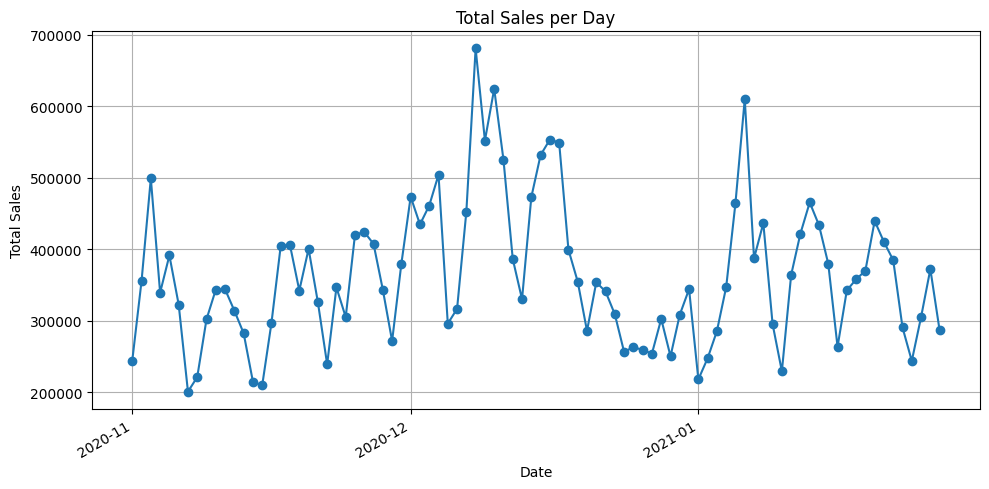

In [ ]:
daily_sales = df_orders.groupby('order_date')['product_price'].sum()

plt.figure(figsize=(10, 5))
plt.plot(daily_sales.index, daily_sales.values, marker='o', linestyle='-')

plt.title('Total Sales per Day')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

Динаміка продажів в Америці, Азії та Європі,  різні континенти відображені різними кольорами.


<ipython-input-264-f2ffcdf32f7a>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(top_3_continents))


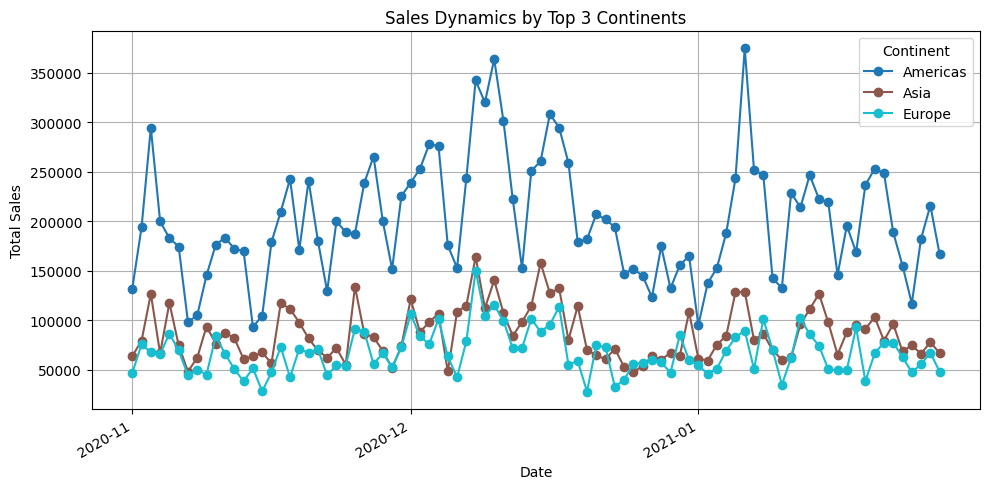

In [ ]:
top_3_continents = df_orders.groupby('continent')['product_price'].sum().nlargest(3).index.tolist()
top_3_continents_df = df_orders[df_orders['continent'].isin(top_3_continents)]
colors = plt.cm.get_cmap('tab10', len(top_3_continents))

plt.figure(figsize=(10, 5))

for i, continent in enumerate(top_3_continents):
    continent_sales = top_3_continents_df[top_3_continents_df['continent'] == continent].groupby('order_date')['product_price'].sum()
    plt.plot(continent_sales.index, continent_sales.values, marker='o', linestyle='-', label=continent, color=colors(i))

plt.title('Sales Dynamics by Top 3 Continents')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend(title='Continent')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

Графік показує, що найбільші продажі по континентам у Америці, далі Азія, далі Європа. Відбуваються постійні коливання. По Америці бачимо 3 великих піка. в середині грудня та на початку січня. Продажі у Європі більш стабільні, ніж у Азії.

Динаміка продажів у розрізі каналів трафіку, різні канали відображені різними кольорами

<ipython-input-265-d0019eff1025>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_channels = plt.cm.get_cmap('tab20', len(channels))


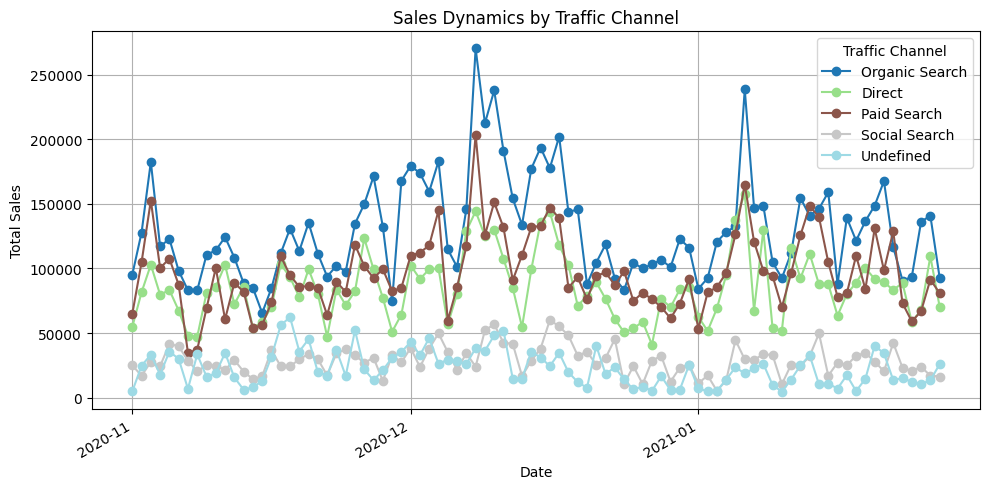

In [ ]:
channels = df_orders['channel'].unique()
colors_channels = plt.cm.get_cmap('tab20', len(channels))

plt.figure(figsize=(10, 5))

for i, channel in enumerate(channels):
    channel_sales = df_orders[df_orders['channel'] == channel].groupby('order_date')['product_price'].sum()
    plt.plot(channel_sales.index, channel_sales.values, marker='o', linestyle='-', label=channel, color=colors_channels(i))

plt.title('Sales Dynamics by Traffic Channel')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend(title='Traffic Channel')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


Графік показує, що найбільші продажі по каналам по оргаічному каналу, а найменьші - по невизначенному. Відбуваються постійні коливання. Так само, як по континентам є 3 великих піка: в середині грудня та на початку січня.

Динаміка продажів у розрізі типів девайсів, різні девайси відображені різними кольорами

<ipython-input-266-d7bad7700575>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_devices = plt.cm.get_cmap('Accent', len(devices))


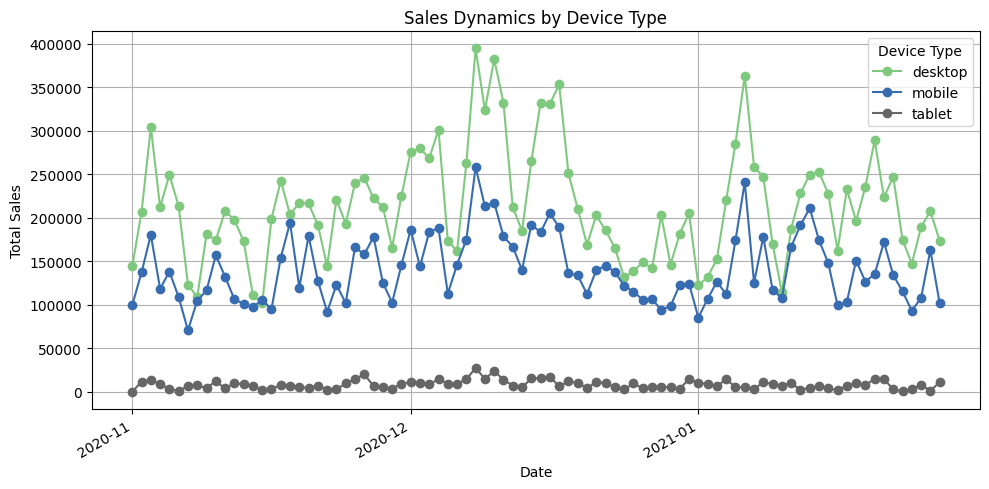

In [ ]:
devices = df_orders['device'].unique()
colors_devices = plt.cm.get_cmap('Accent', len(devices))

plt.figure(figsize=(10, 5))

for i, device in enumerate(devices):
    device_sales = df_orders[df_orders['device'] == device].groupby('order_date')['product_price'].sum()
    plt.plot(device_sales.index, device_sales.values, marker='o', linestyle='-', label=device, color=colors_devices(i))

plt.title('Sales Dynamics by Device Type')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend(title='Device Type')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

Графік показує, що найбільші продажі по девайсам через десктоп, далі мобільний, далі планшет. Відбуваються постійні коливання. Так само є 3 великих піка: в середині грудня та на початку січня.

Висновки: Усі графіки показують зростання продажів у період різдвяних свят.

###5. Зведені таблиці.
Кількість сесій у розрізі каналів трафіку та типів девайсів:




In [ ]:
pivot_table = df_filled.pivot_table(
    index='channel',
    columns='device',
    values='session_id',
    aggfunc='count',
    dropna=True
)

print(pivot_table)

device          desktop  mobile  tablet
channel                                
Direct            47825   31745    1812
Organic Search    72622   49014    2789
Paid Search       55167   37034    2140
Social Search     16288   10988     638
Undefined         12527    8486     470


Загальні продажі за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)

country                              Canada    France      India  \
product_category                                                   
Bar furniture                       51724.0   11199.0    57657.0   
Beds                               354772.0  116414.0   358319.5   
Bookcases & shelving units         278981.9   73830.0   364507.4   
Cabinets & cupboards               181802.0   59101.5   191888.0   
Chairs                             417740.8  134029.4   544309.2   
Chests of drawers & drawer units    71952.0   21544.5    73111.0   
Children's furniture                30264.0   14258.0    39177.0   
Outdoor furniture                  185322.8   40486.4   162289.4   
Sofas & armchairs                  692427.5  187735.0   788430.0   
Tables & desks                     132678.0   42299.0   186157.5   
Total                             2397665.0  700896.8  2765846.0   

country                           United Kingdom  United States       Total  
product_category                     

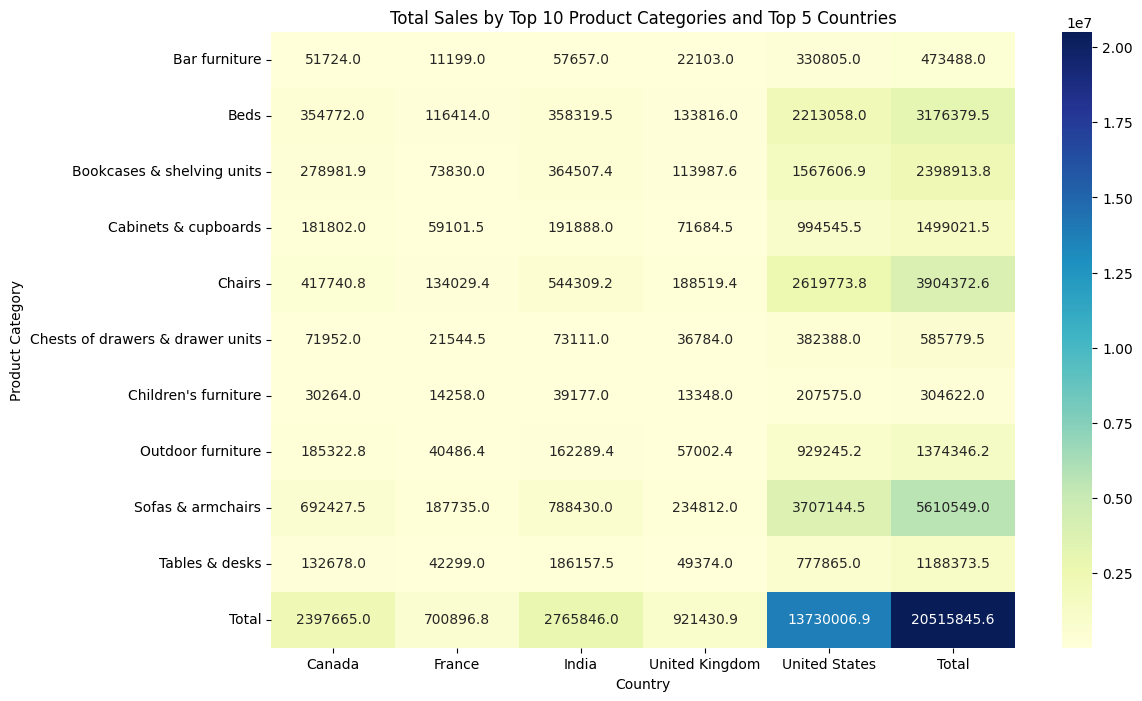

In [ ]:
top_10_categories = df_orders.groupby('product_category')['product_price'].sum().nlargest(10).index.tolist()

top_5_countries = df_orders.groupby('country')['product_price'].sum().nlargest(5).index.tolist()

filtered_df = df_orders[df_orders['product_category'].isin(top_10_categories) & df_orders['country'].isin(top_5_countries)]

pivot_table_sales = filtered_df.pivot_table(
    index='product_category',
    columns='country',
    values='product_price',
    aggfunc='sum',
    margins=True,
    margins_name='Total'
)
print(pivot_table_sales)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table_sales, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Total Sales by Top 10 Product Categories and Top 5 Countries")
plt.xlabel("Country")
plt.ylabel("Product Category")
plt.show()


Середня ціна товару за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)

country                                Canada       France        India  \
product_category                                                          
Bar furniture                      623.180723   658.764706   600.593750   
Beds                              1627.394495  2078.821429  1518.302966   
Bookcases & shelving units         472.050592   512.708333   496.604087   
Cabinets & cupboards               988.054348  1158.852941   954.666667   
Chairs                             928.312889  1155.425862  1009.850093   
Chests of drawers & drawer units   636.743363   673.265625   566.751938   
Children's furniture               260.896552   309.956522   275.894366   
Outdoor furniture                 1047.021469  1065.431579   886.827322   
Sofas & armchairs                 2091.925982  2063.021978  1990.984848   
Tables & desks                     605.835616   704.983333   648.632404   
Average                            966.021354  1076.646390   939.804961   

country                 

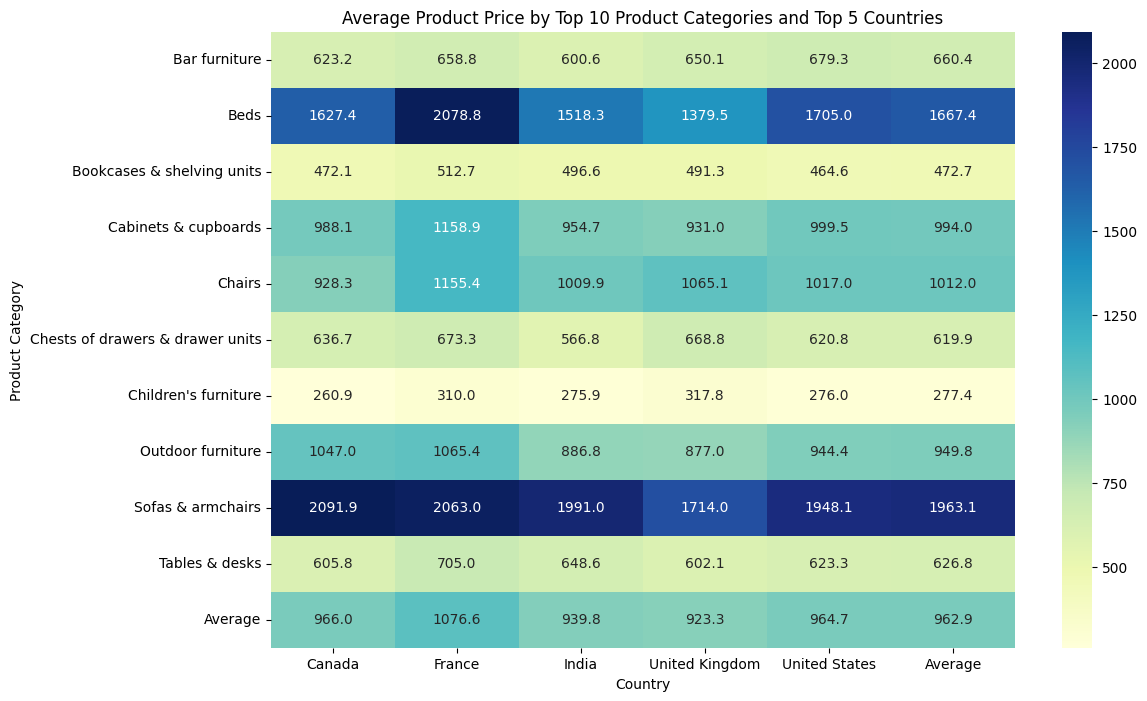

In [ ]:
pivot_table_avg_price = filtered_df.pivot_table(
    index='product_category',
    columns='country',
    values='product_price',
    aggfunc='mean',
    margins=True,
    margins_name='Average'
)

print(pivot_table_avg_price)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table_avg_price, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average Product Price by Top 10 Product Categories and Top 5 Countries")
plt.xlabel("Country")
plt.ylabel("Product Category")
plt.show()


Кількість проданих товарів за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)

country                           Canada  France  India  United Kingdom  \
product_category                                                          
Bar furniture                         83      17     96              34   
Beds                                 218      56    236              97   
Bookcases & shelving units           591     144    734             232   
Cabinets & cupboards                 184      51    201              77   
Chairs                               450     116    539             177   
Chests of drawers & drawer units     113      32    129              55   
Children's furniture                 116      46    142              42   
Outdoor furniture                    177      38    183              65   
Sofas & armchairs                    331      91    396             137   
Tables & desks                       219      60    287              82   
Count                               2482     651   2943             998   

country                 

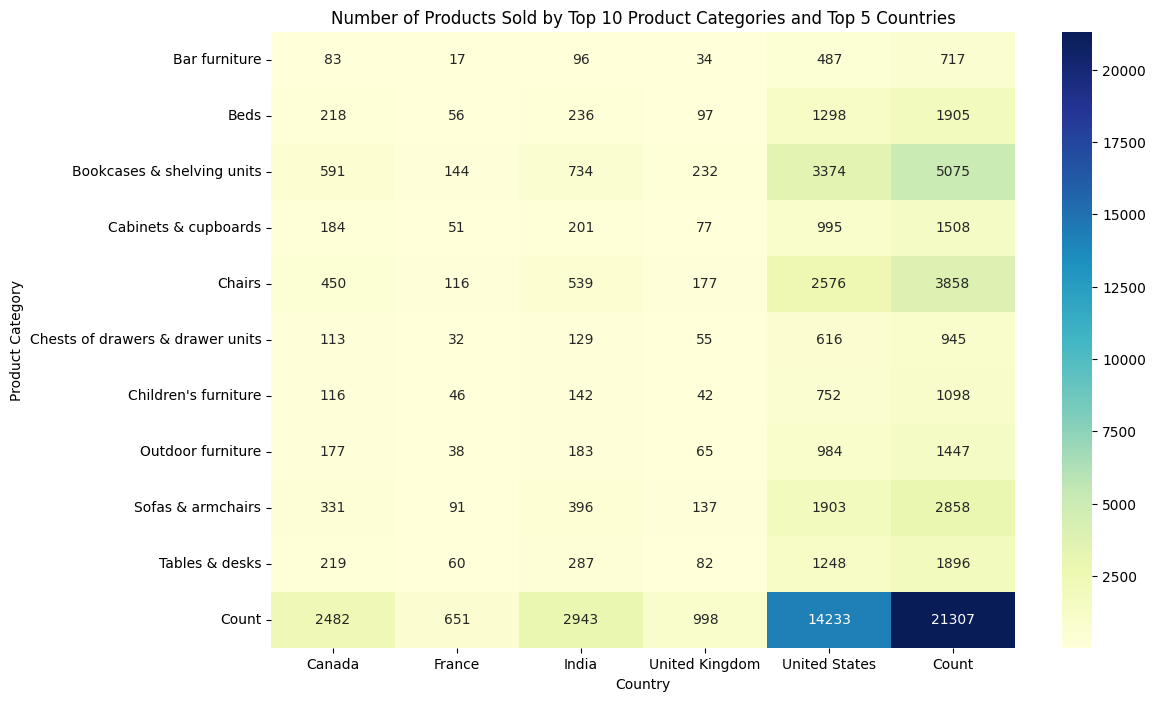

In [ ]:
pivot_table_count = filtered_df.pivot_table(
    index='product_category',
    columns='country',
    values='product_price',
    aggfunc='count',
    margins=True,
    margins_name='Count'
)

print(pivot_table_count)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table_count, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Number of Products Sold by Top 10 Product Categories and Top 5 Countries")
plt.xlabel("Country")
plt.ylabel("Product Category")
plt.show()


###6. Статистичний аналіз взаємозв’язків.



Кількість сесій та загальні продажі за кожну дату. Візуалізацію, щоб побачити взаємозв’язок між цими метриками. Чи корелюють ці показники? Знайди відповідний коефіцієнт кореляції та проаналізуй його статистичну значущість.



   order_date  session_count  total_sales
0  2020-11-01            281     244292.5
1  2020-11-02            368     355506.8
2  2020-11-03            561     498979.6
3  2020-11-04            370     339187.1
4  2020-11-05            388     391276.6
..        ...            ...          ...
83 2021-01-23            313     290605.5
84 2021-01-24            296     243818.4
85 2021-01-25            370     305089.3
86 2021-01-26            385     372057.3
87 2021-01-27            299     286340.7

[88 rows x 3 columns]


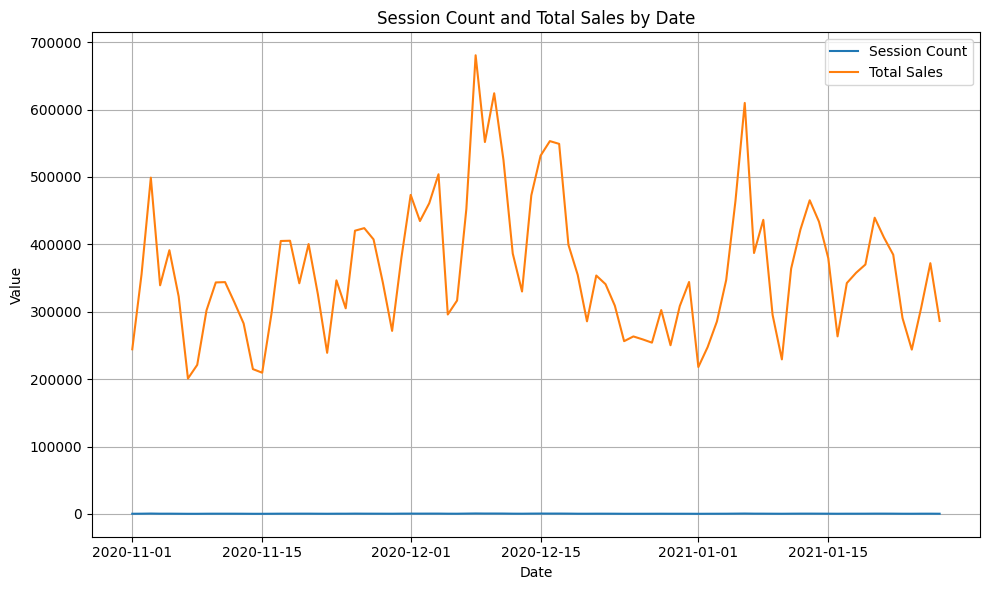

Pearson Correlation Coefficient: 0.9642422533124871
P-value: 2.2447783149167257e-51
Correlation is statistically significant.
There is a positive correlation between session count and total sales.


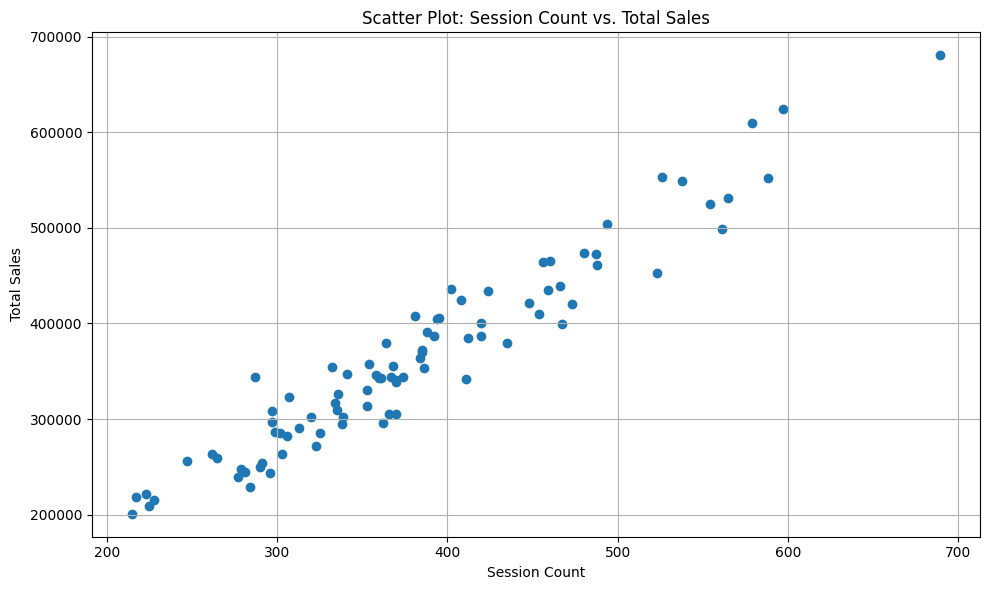

In [ ]:
daily_data = df_orders.groupby('order_date').agg(
    session_count=('session_id', 'nunique'),
    total_sales=('product_price', 'sum')
).reset_index()
print(daily_data)

plt.figure(figsize=(10, 6))
plt.plot(daily_data['order_date'], daily_data['session_count'], label='Session Count')
plt.plot(daily_data['order_date'], daily_data['total_sales'], label='Total Sales')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Session Count and Total Sales by Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

correlation = stats.pearsonr(daily_data['session_count'], daily_data['total_sales'])
print(f"Pearson Correlation Coefficient: {correlation.statistic}")
print(f"P-value: {correlation.pvalue}")

if correlation.pvalue < 0.05:
    print("Correlation is statistically significant.")
    if correlation.statistic > 0:
        print("There is a positive correlation between session count and total sales.")
    elif correlation.statistic < 0:
        print("There is a negative correlation between session count and total sales.")
else:
    print("Correlation is not statistically significant.")

plt.figure(figsize=(10, 6))
plt.scatter(daily_data['session_count'], daily_data['total_sales'])
plt.xlabel('Session Count')
plt.ylabel('Total Sales')
plt.title('Scatter Plot: Session Count vs. Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()


Кількість сесій та загальні продажі за кожну дату знайдені. Візуалізація, щоб побачити взаємозв’язок між цими метриками, зроблена. Ці показники корелюють, позитивна кореляція дуже сильна, коефіцієнт майже +1 (0.9642422533124871). Коефіцієнт кореляції статистично значущий тому що P-value: 2.2447783149167257e-51.


Чи корелюють між собою продажі на різних континентах? По топ-3 континентам. Аналіз статистичної значущості взаємозв’язків.


In [ ]:
top_continents = df_orders.groupby('continent')['product_price'].sum().nlargest(3).index.tolist()

df_top_continents = df_orders[df_orders['continent'].isin(top_continents)]

continent_sales = df_top_continents.groupby(['order_date', 'continent'])['product_price'].sum().unstack()

continent_correlation_matrix = continent_sales.corr()
print("Correlation matrix for top-3 continents:\n", continent_correlation_matrix)

print("\nSignificance analysis of correlations between continents:")
for i in range(len(top_continents)):
    for j in range(i + 1, len(top_continents)):
        continent1 = top_continents[i]
        continent2 = top_continents[j]

        if continent1 in continent_sales.columns and continent2 in continent_sales.columns:

            sales1 = continent_sales[continent1].dropna()
            sales2 = continent_sales[continent2].dropna()

            if not sales1.empty and not sales2.empty:
                correlation = stats.pearsonr(sales1, sales2)
                print(f"Correlation between {continent1} and {continent2}:")
                print(f"  Correlation coefficient: {correlation.statistic}")
                print(f"  P-value: {correlation.pvalue}")
                alpha = 0.05
                if correlation.pvalue < alpha:
                    print("  Correlation is statistically significant.")
                else:
                    print("  Correlation is not statistically significant.")
            else:
                print(f"Insufficient common data for correlation between {continent1} and {continent2}")
        else:
            print(f"No data for one of the continents: {continent1} or {continent2}")
        print("-" * 30)



Correlation matrix for top-3 continents:
 continent  Americas      Asia    Europe
continent                              
Americas   1.000000  0.692273  0.669527
Asia       0.692273  1.000000  0.667786
Europe     0.669527  0.667786  1.000000

Significance analysis of correlations between continents:
Correlation between Americas and Asia:
  Correlation coefficient: 0.6922725921166172
  P-value: 8.004062946873886e-14
  Correlation is statistically significant.
------------------------------
Correlation between Americas and Europe:
  Correlation coefficient: 0.6695272265974656
  P-value: 9.911408291629284e-13
  Correlation is statistically significant.
------------------------------
Correlation between Asia and Europe:
  Correlation coefficient: 0.6677857678141951
  P-value: 1.190892903263713e-12
  Correlation is statistically significant.
------------------------------


Продажі на різних континентах корелюють між собою, кореляція сильна, позитивна, результат статистично значущий.

Чи корелюють між собою продажі за різними каналами трафіку? Аналіз статистичної значущості взаємозв’язків.


In [ ]:
unique_channels = df_orders['channel'].unique().tolist()

channel_sales = df_orders.groupby(['order_date', 'channel'])['product_price'].sum().unstack()

channel_correlation_matrix = channel_sales.corr()
print("\nCorrelation matrix for traffic channels:\n", channel_correlation_matrix)

print("\nSignificance analysis of correlations between traffic channels:")
for i in range(len(unique_channels)):
    for j in range(i + 1, len(unique_channels)):
        channel1 = unique_channels[i]
        channel2 = unique_channels[j]
        if channel1 in channel_sales.columns and channel2 in channel_sales.columns:
            sales1 = channel_sales[channel1].dropna()
            sales2 = channel_sales[channel2].dropna()
            if not sales1.empty and not sales2.empty:
                correlation = stats.pearsonr(sales1, sales2)
                print(f"Correlation between {channel1} and {channel2}:")
                print(f"  Correlation coefficient: {correlation.statistic}")
                print(f"  P-value: {correlation.pvalue}")
                alpha = 0.05
                if correlation.pvalue < alpha:
                    print("  Correlation is statistically significant.")
                else:
                    print("  Correlation is not statistically significant.")
            else:
                print(f"Insufficient common data for correlation between {channel1} and {channel2}")
        else:
            print(f"No data for one of the channels: {channel1} or {channel2}")
        print("-" * 30)


Correlation matrix for traffic channels:
 channel           Direct  Organic Search  Paid Search  Social Search  \
channel                                                                
Direct          1.000000        0.759938     0.724343       0.461895   
Organic Search  0.759938        1.000000     0.808234       0.434424   
Paid Search     0.724343        0.808234     1.000000       0.452287   
Social Search   0.461895        0.434424     0.452287       1.000000   
Undefined       0.424039        0.435418     0.430021       0.359342   

channel         Undefined  
channel                    
Direct           0.424039  
Organic Search   0.435418  
Paid Search      0.430021  
Social Search    0.359342  
Undefined        1.000000  

Significance analysis of correlations between traffic channels:
Correlation between Organic Search and Direct:
  Correlation coefficient: 0.7599378022358332
  P-value: 9.107881327500992e-18
  Correlation is statistically significant.
---------------------

Продажі за різними каналами трафіку позитивно корелюють між собою. Найбільший позитивний звязок між Organic Search and Direct та Organic Search and Paid Search. Решта позитивний звязок мають, але він трохи нижчій за 0,5. Всі взаємозв’язки статистично значущі.

Чи корелюють між собою продажі за топ-5 категоріями товарів? Аналіз статистичної значущості взаємозв’язків.

In [ ]:
top_categories = df_orders.groupby('product_category')['product_price'].sum().nlargest(5).index.tolist()
df_top_categories = df_orders[df_orders['product_category'].isin(top_categories)]

category_sales = df_top_categories.groupby(['order_date', 'product_category'])['product_price'].sum().unstack()

category_correlation_matrix = category_sales.corr()
print("\nCorrelation matrix for top-5 product categories:\n", category_correlation_matrix)

print("\nSignificance analysis of correlations between product categories:")
for i in range(len(top_categories)):
    for j in range(i + 1, len(top_categories)):
        category1 = top_categories[i]
        category2 = top_categories[j]
        if category1 in category_sales.columns and category2 in category_sales.columns:
            sales1 = category_sales[category1].dropna()
            sales2 = category_sales[category2].dropna()
            if not sales1.empty and not sales2.empty:
                correlation = stats.pearsonr(sales1, sales2)
                print(f"Correlation between {category1} and {category2}:")
                print(f"  Correlation coefficient: {correlation.statistic}")
                print(f"  P-value: {correlation.pvalue}")
                alpha = 0.05
                if correlation.pvalue < alpha:
                    print("  Correlation is statistically significant.")
                else:
                    print("  Correlation is not statistically significant.")
            else:
                print(f"Insufficient common data for correlation between {category1} and {category2}")
        else:
            print(f"No data for one of the categories: {category1} or {category2}")
        print("-" * 30)


Correlation matrix for top-5 product categories:
 product_category                Beds  Bookcases & shelving units  \
product_category                                                   
Beds                        1.000000                    0.592913   
Bookcases & shelving units  0.592913                    1.000000   
Cabinets & cupboards        0.514609                    0.539428   
Chairs                      0.554500                    0.637090   
Sofas & armchairs           0.535378                    0.666194   

product_category            Cabinets & cupboards    Chairs  Sofas & armchairs  
product_category                                                               
Beds                                    0.514609  0.554500           0.535378  
Bookcases & shelving units              0.539428  0.637090           0.666194  
Cabinets & cupboards                    1.000000  0.572870           0.657563  
Chairs                                  0.572870  1.000000           0.5

Продажі за топ-5 категоріями товарів позитивно корелюють між собою. Позитивний звязок мають всі категорії, коефіцієнт кореляції трохи вище за 0,5. Всі взаємозв’язки статистично значущі.

Чи корелюють між собою продажі за браузерами? Аналіз статистичної значущості взаємозв’язків.

In [ ]:
unique_browsers = df_orders['browser'].unique().tolist()

browser_sales = df_orders.groupby(['order_date', 'browser'])['product_price'].sum().unstack()

browser_correlation_matrix = browser_sales.corr()
print("\nCorrelation matrix for browsers:\n", browser_correlation_matrix)

print("\nSignificance analysis of correlations between browsers:")
for i in range(len(unique_browsers)):
    for j in range(i + 1, len(unique_browsers)):
        browser1 = unique_browsers[i]
        browser2 = unique_browsers[j]

        if browser1 in browser_sales.columns and browser2 in browser_sales.columns:
            sales1 = browser_sales[browser1].dropna()
            sales2 = browser_sales[browser2].dropna()

            if sales1.size == sales2.size and not sales1.empty:
                correlation = stats.pearsonr(sales1, sales2)
                print(f"Correlation between {browser1} and {browser2}:")
                print(f"  Correlation coefficient: {correlation.statistic}")
                print(f"  P-value: {correlation.pvalue}")
                alpha = 0.05
                if correlation.pvalue < alpha:
                    print("  Correlation is statistically significant.")
                else:
                    print("  Correlation is not statistically significant.")
            else:
                print(f"Insufficient common data for correlation between {browser1} and {browser2}")
        else:
            print(f"No data for one of the browsers: {browser1} or {browser2}")
        print("-" * 30)



Correlation matrix for browsers:
 browser           <Other>  Android Webview    Chrome      Edge   Firefox  \
browser                                                                    
<Other>          1.000000         0.177118  0.420688  0.369672  0.136187   
Android Webview  0.177118         1.000000  0.331601  0.089759 -0.062282   
Chrome           0.420688         0.331601  1.000000  0.526922  0.391384   
Edge             0.369672         0.089759  0.526922  1.000000  0.116943   
Firefox          0.136187        -0.062282  0.391384  0.116943  1.000000   
Safari           0.451811         0.248224  0.816345  0.480802  0.398303   

browser            Safari  
browser                    
<Other>          0.451811  
Android Webview  0.248224  
Chrome           0.816345  
Edge             0.480802  
Firefox          0.398303  
Safari           1.000000  

Significance analysis of correlations between browsers:
Correlation between Chrome and Safari:
  Correlation coefficient: 0.8163454

Продажі за браузерами позитивно корелюють між собою, найвищий показник по Chrome and Safari. Решта мають значно менший коефіцієнт кореляції, навіть 0.3. Результати, що менші за 0.1 не є статистично значущими. Всі взаємозв’язки статистично значущі, окрім Edge and Firefox, Firefox and Other. Але занадто мало спільних дат, для яких є дані одночасно для Chrome і для Android Webview, Safari and Android Webview, Edge and Android Webview, Firefox and Android Webview та Other and Android Webview тому у цих випадках неможливо провести аналіз.

Графіки scatter plots, щоб показати взаємозвязки між континентами

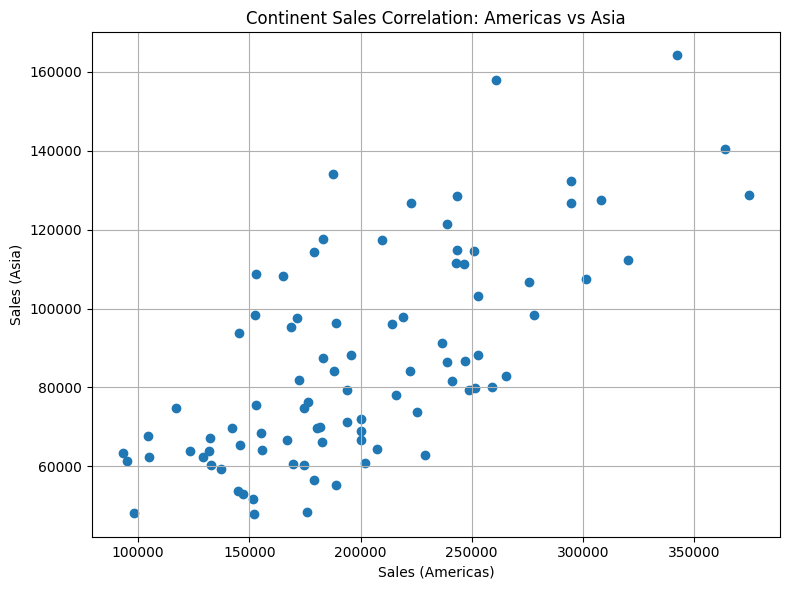

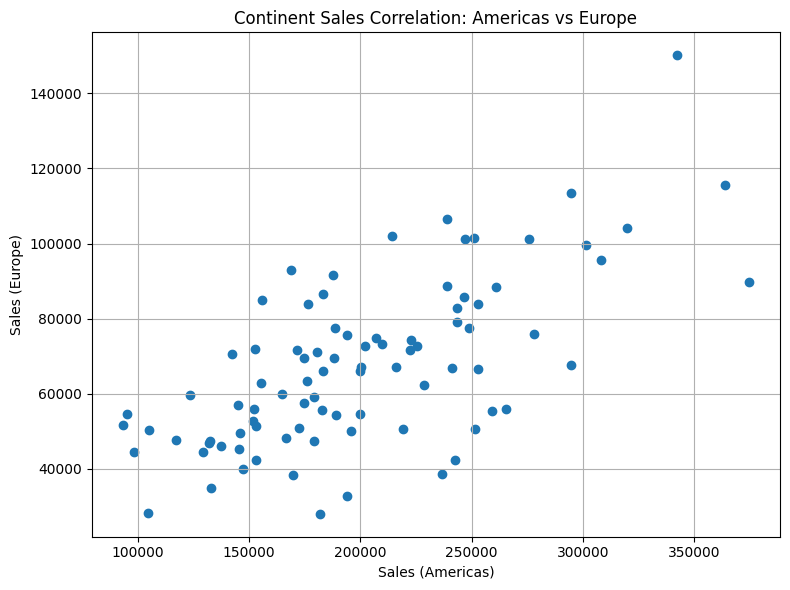

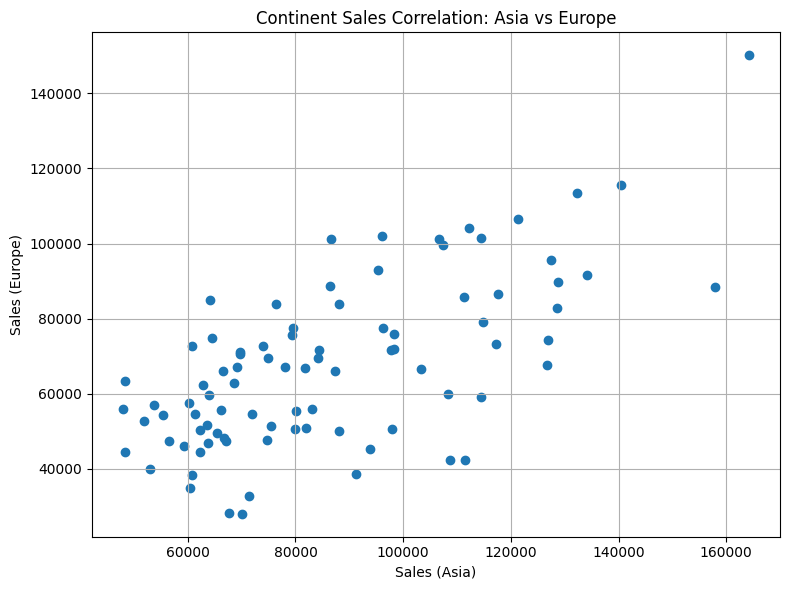

In [ ]:
def create_scatter_plots(data, title_prefix, x_label, y_label):
    """Creates scatter plots for all pairs of columns in the given DataFrame."""
    columns = data.columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1 = columns[i]
            col2 = columns[j]
            plt.figure(figsize=(8, 6))
            plt.scatter(data[col1], data[col2])
            plt.xlabel(x_label + f" ({col1})")
            plt.ylabel(y_label + f" ({col2})")
            plt.title(f"{title_prefix}: {col1} vs {col2}")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

top_continents = df_orders.groupby('continent')['product_price'].sum().nlargest(3).index.tolist()

df_top_continents = df_orders[df_orders['continent'].isin(top_continents)]

continent_sales = df_top_continents.groupby(['order_date', 'continent'])['product_price'].sum().unstack()

create_scatter_plots(continent_sales, "Continent Sales Correlation", "Sales", "Sales")



Графіки scatter plots, щоб показати взаємозвязки між каналами трафіку

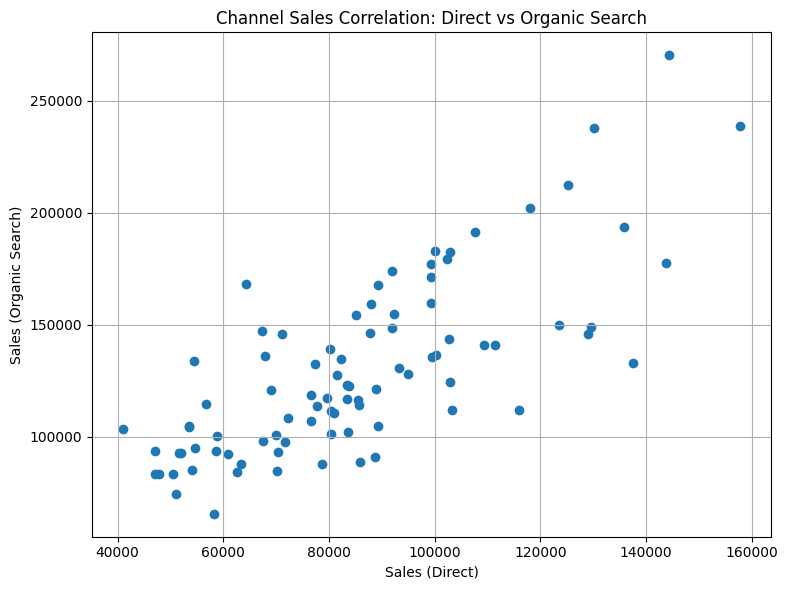

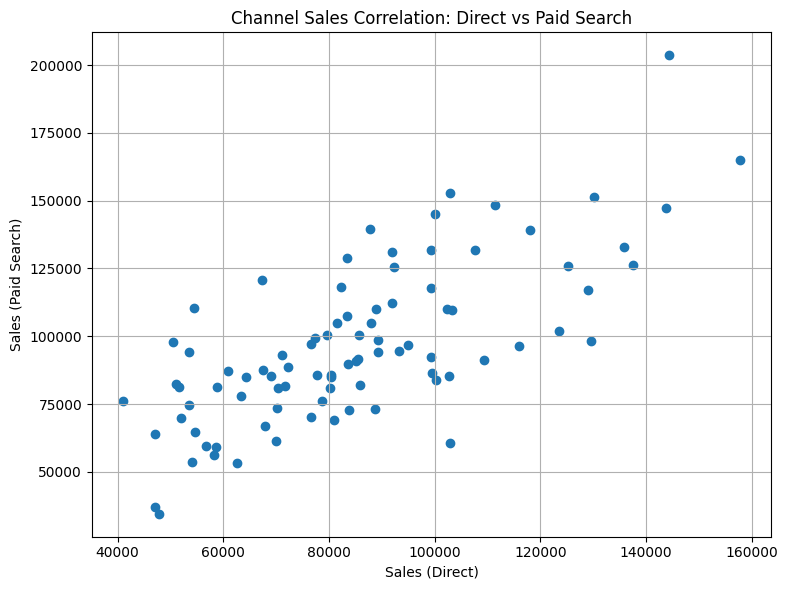

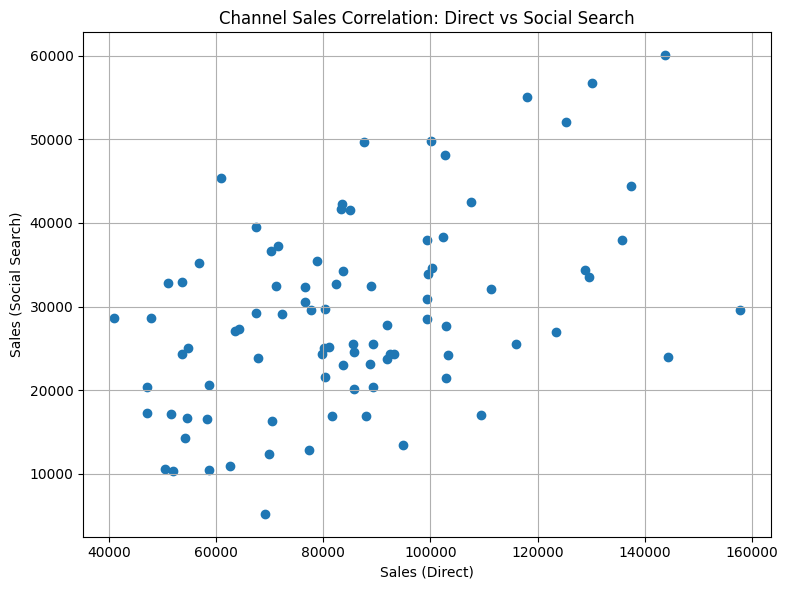

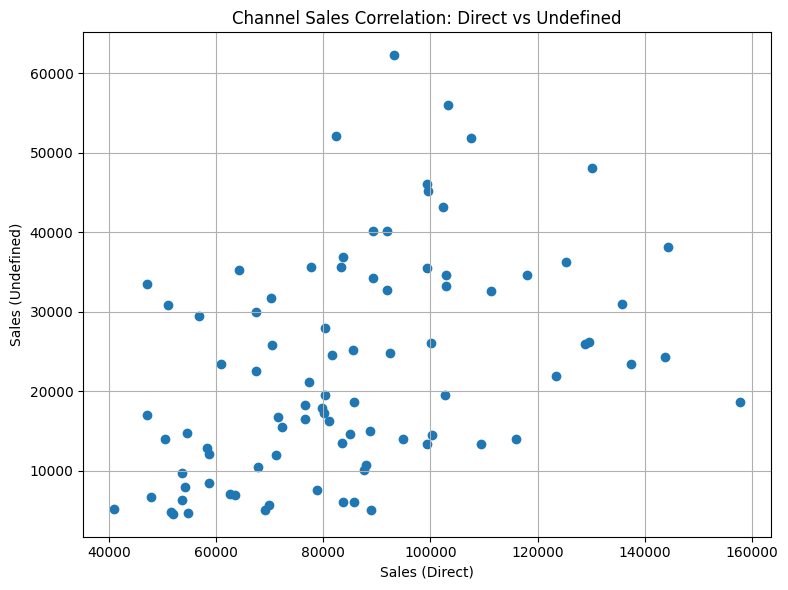

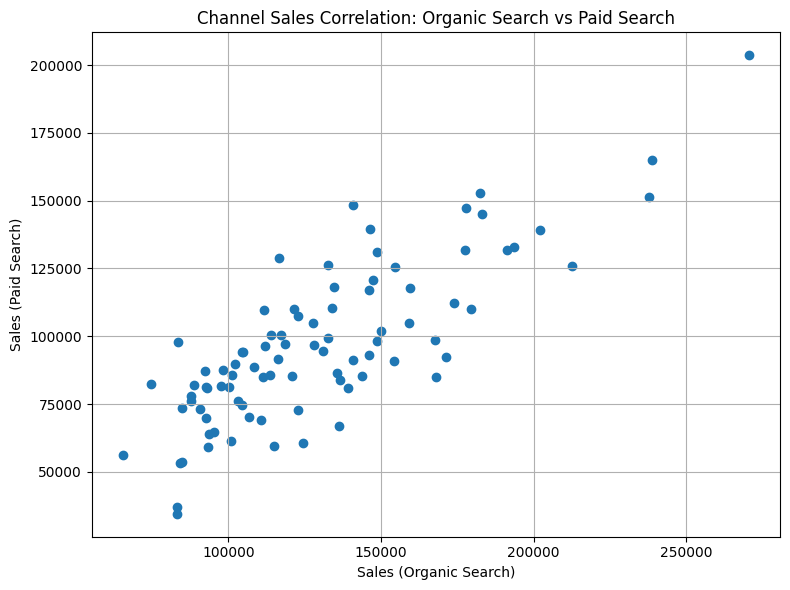

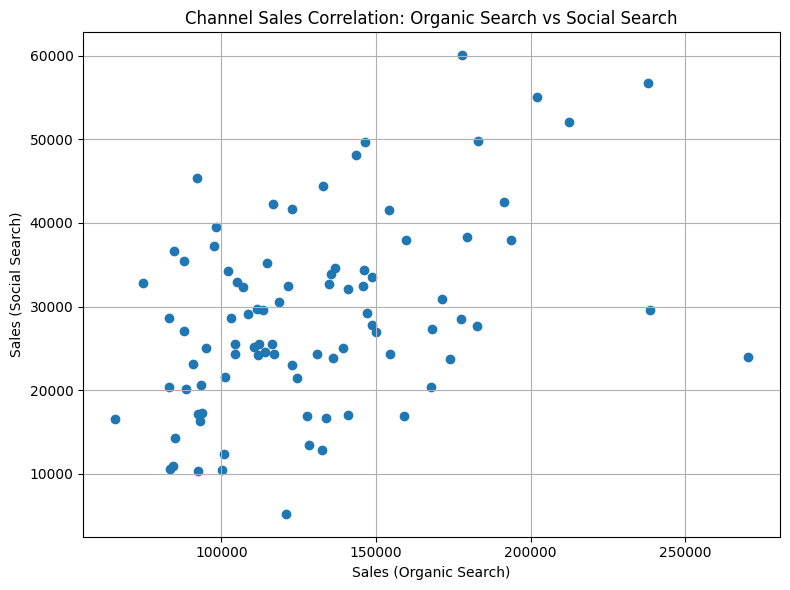

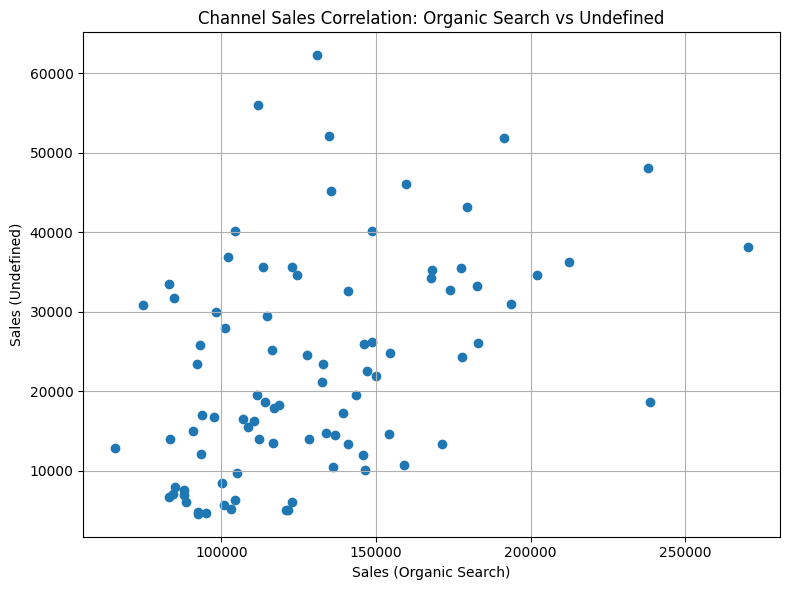

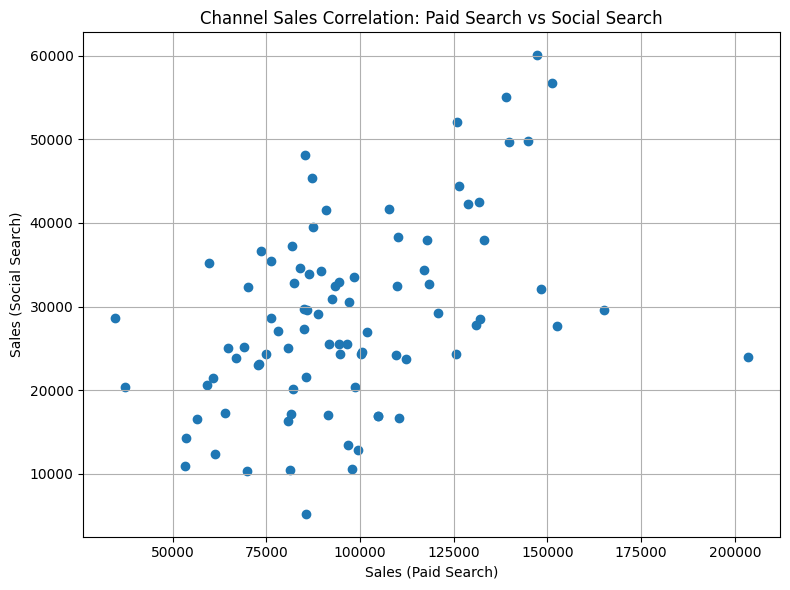

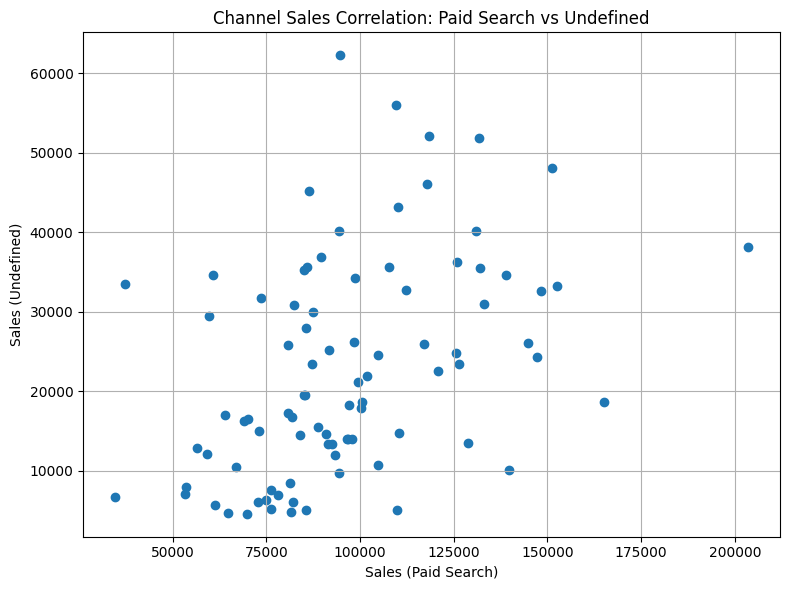

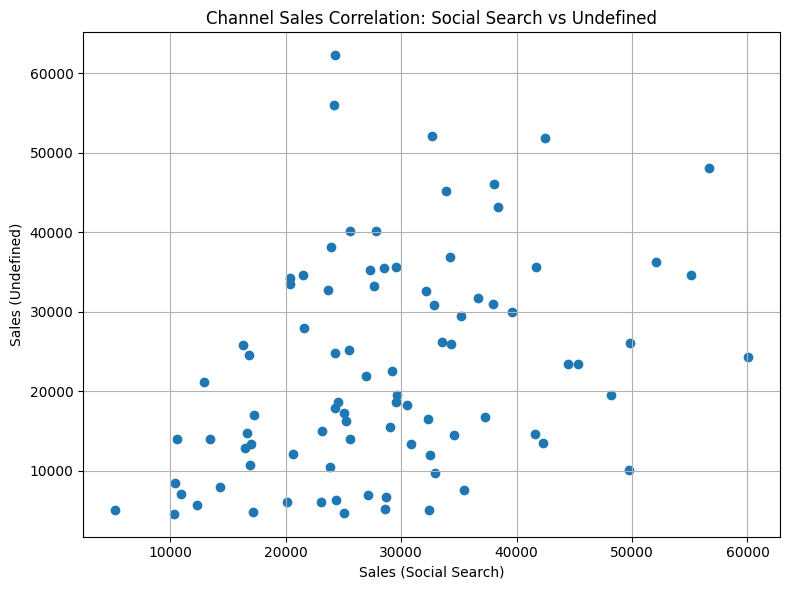

In [ ]:
unique_channels = df_orders['channel'].unique().tolist()

channel_sales = df_orders.groupby(['order_date', 'channel'])['product_price'].sum().unstack()

create_scatter_plots(channel_sales, "Channel Sales Correlation", "Sales", "Sales")

Графіки scatter plots, щоб показати взаємозвязки між категоріями

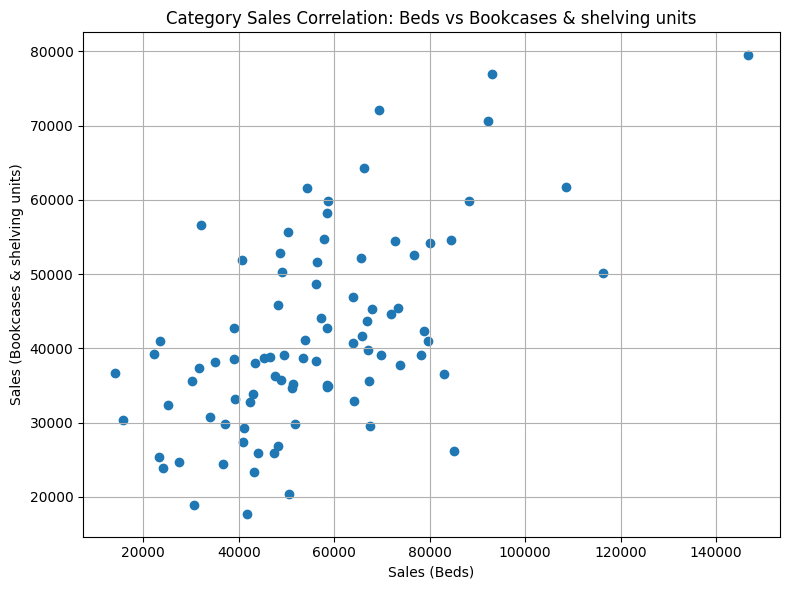

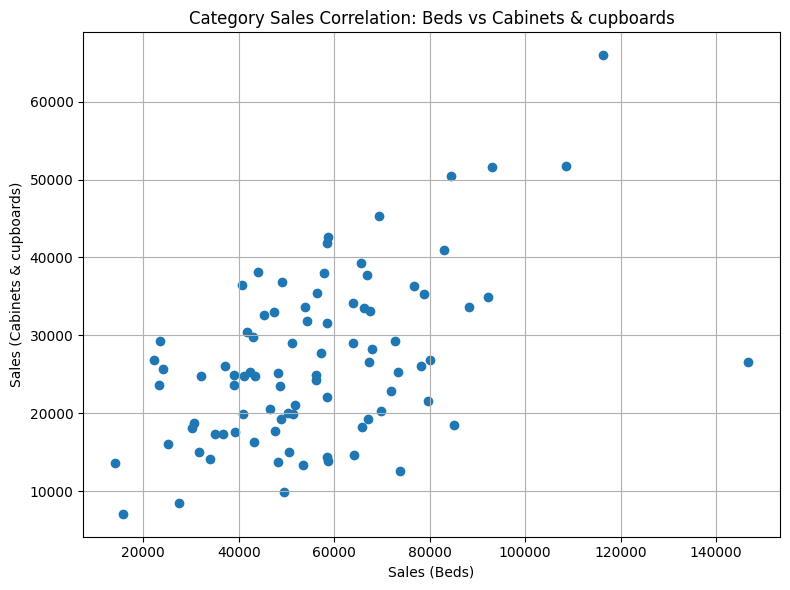

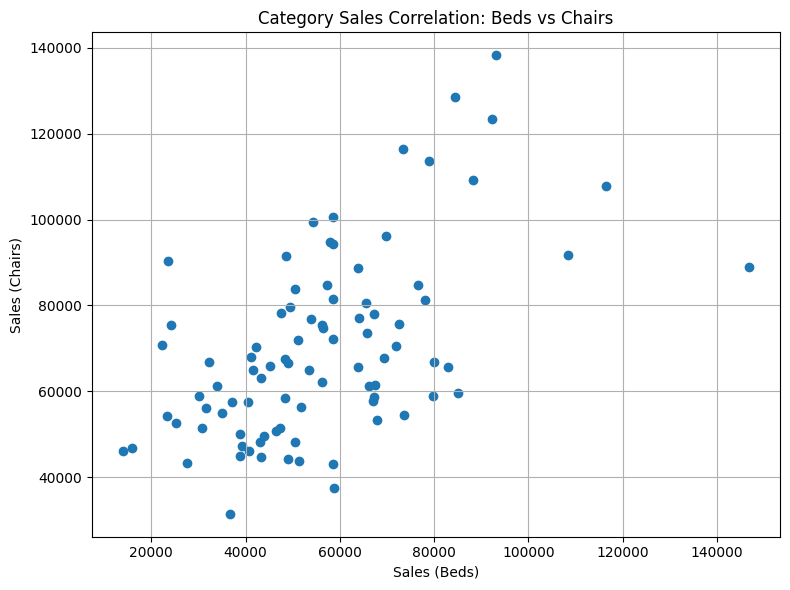

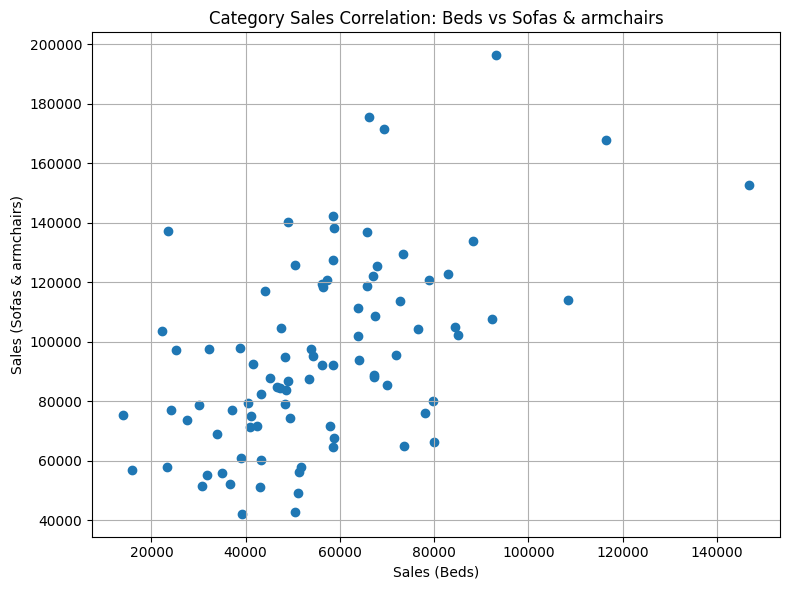

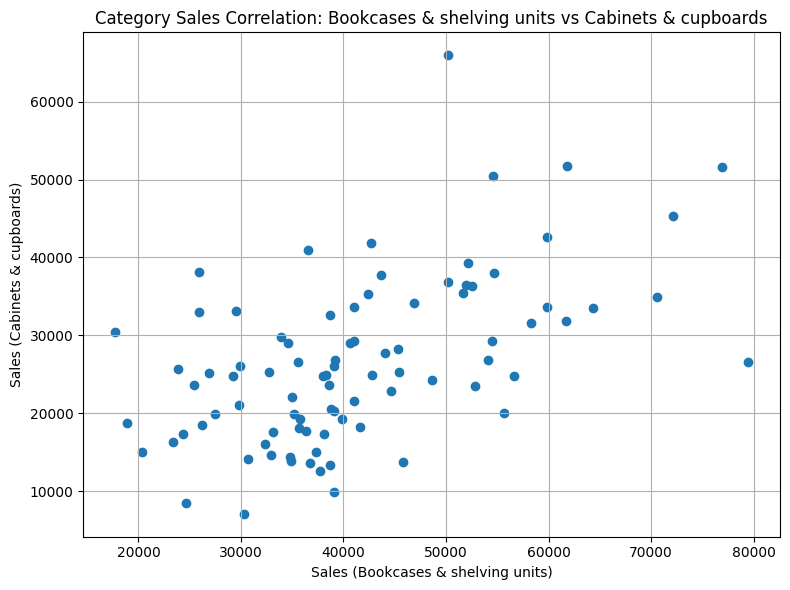

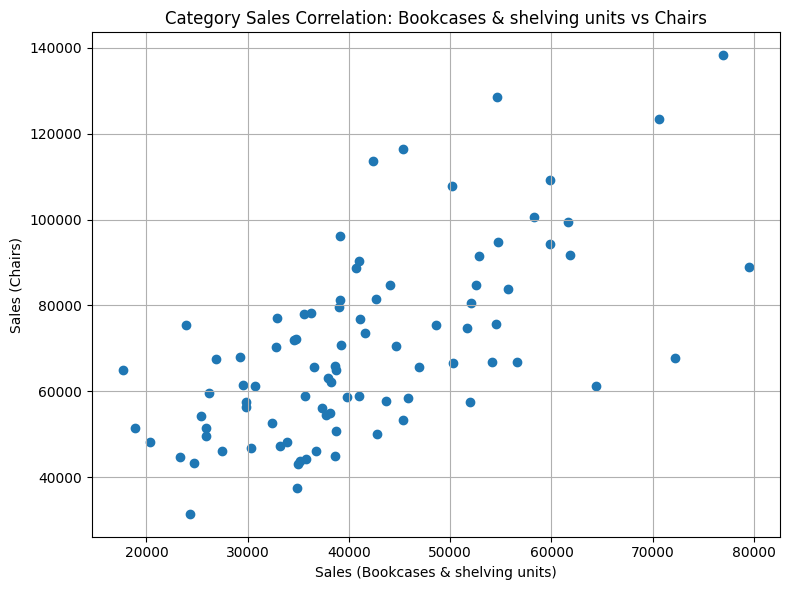

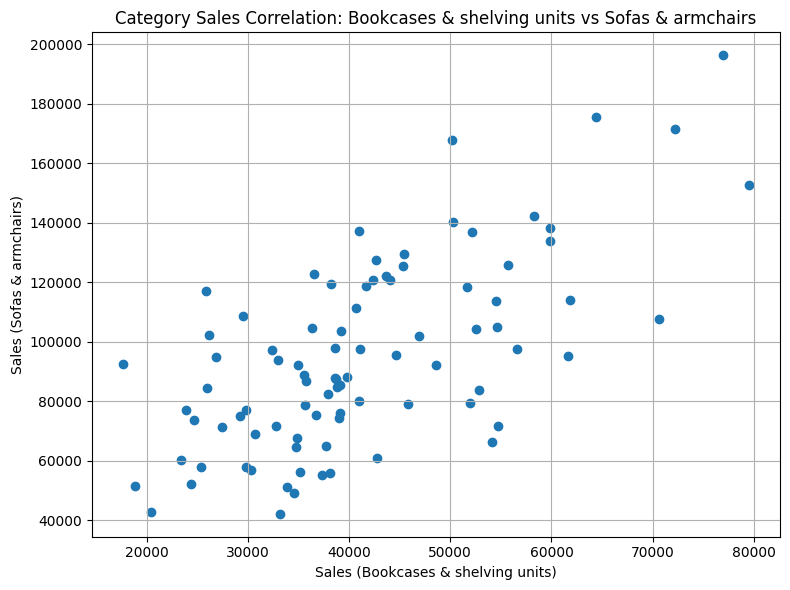

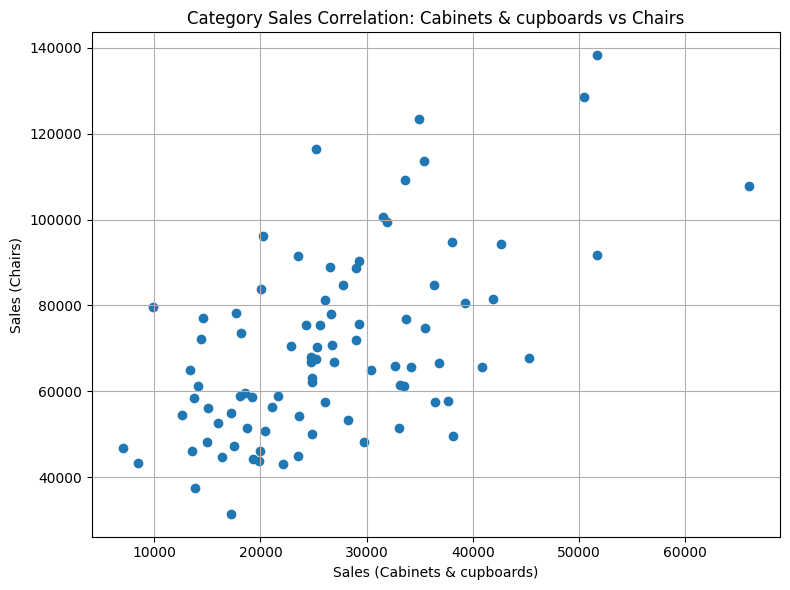

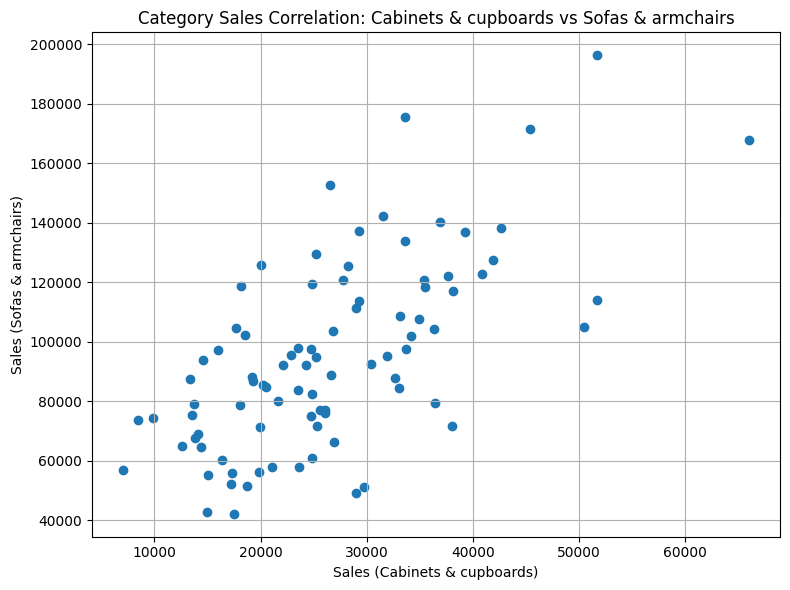

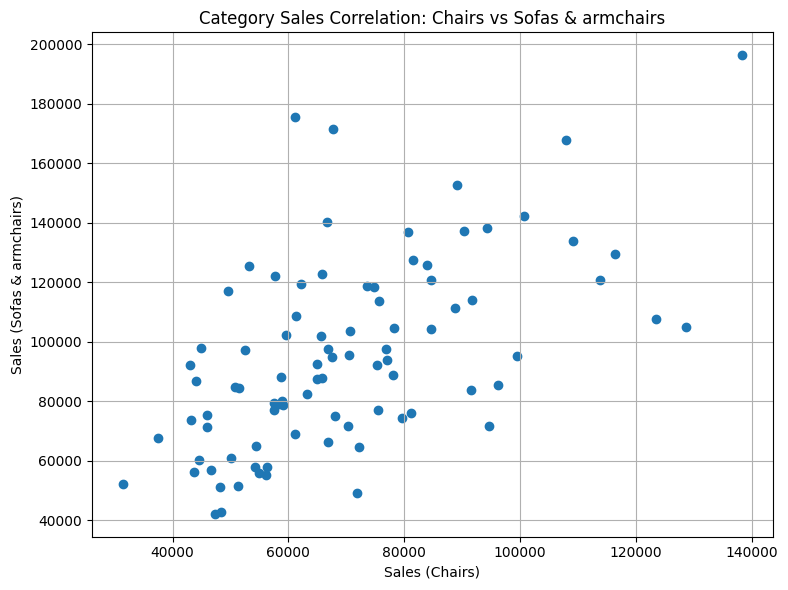

In [ ]:
top_categories = df_orders.groupby('product_category')['product_price'].sum().nlargest(5).index.tolist()

df_top_categories = df_orders[df_orders['product_category'].isin(top_categories)]

category_sales = df_top_categories.groupby(['order_date', 'product_category'])['product_price'].sum().unstack()

create_scatter_plots(category_sales, "Category Sales Correlation", "Sales", "Sales")

Графіки scatter plots, щоб показати взаємозвязки між браузерами

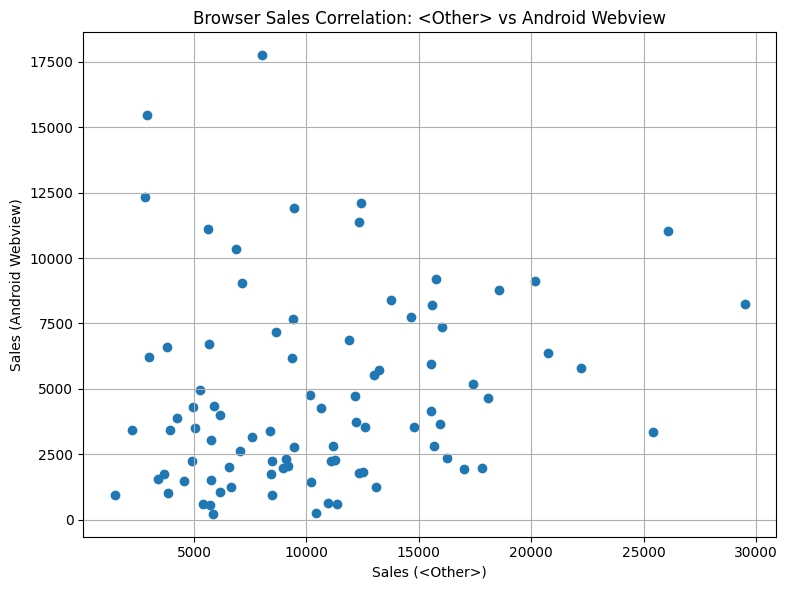

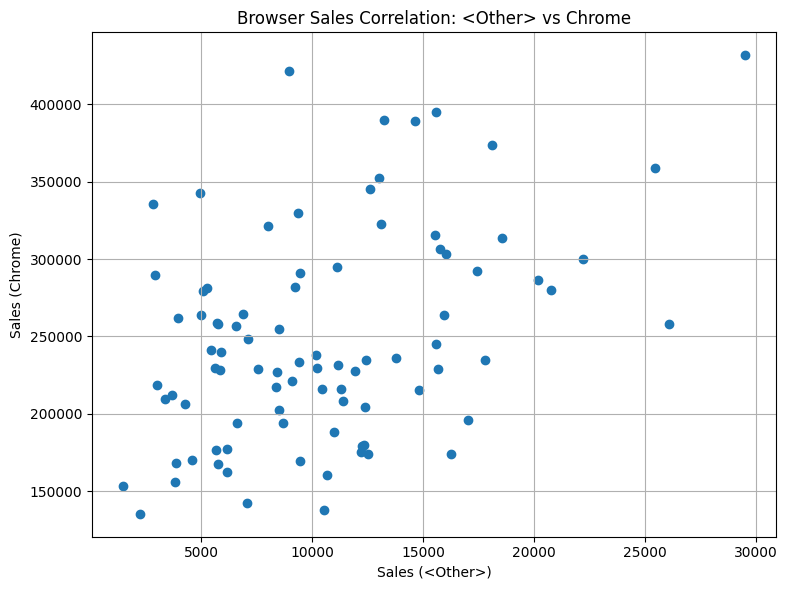

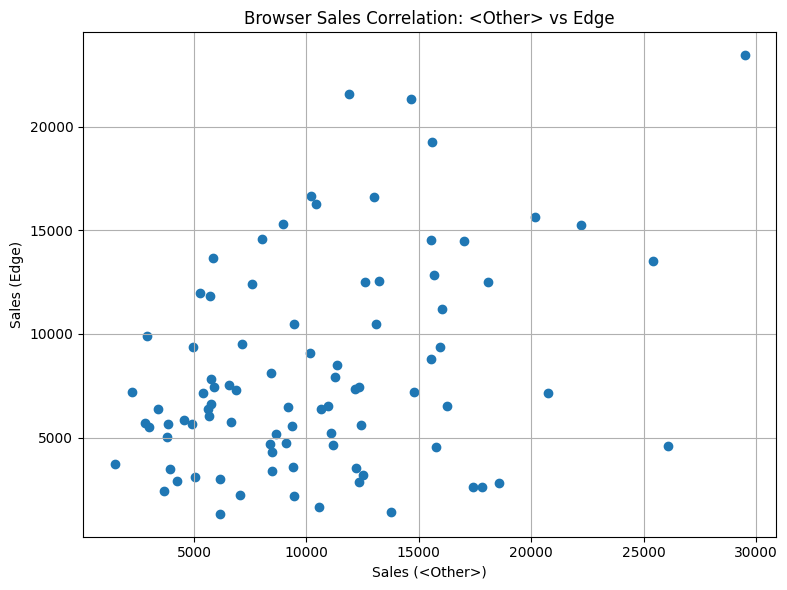

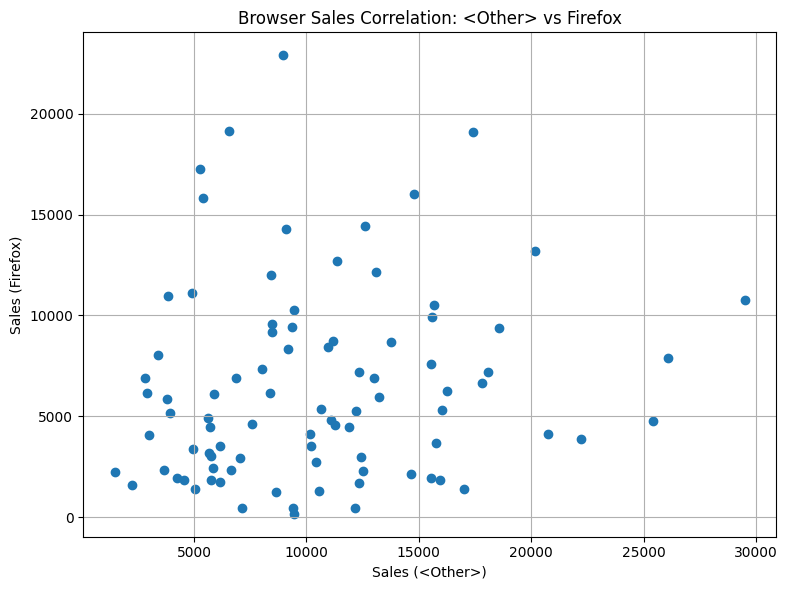

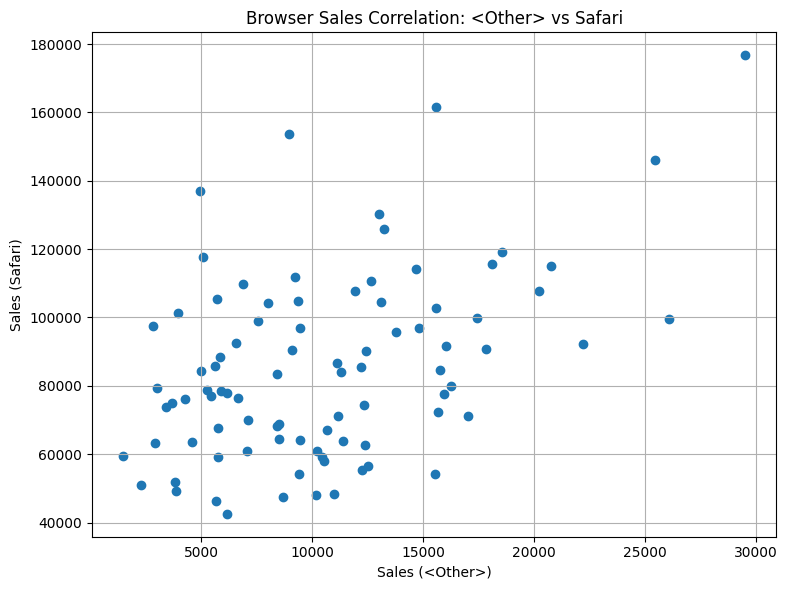

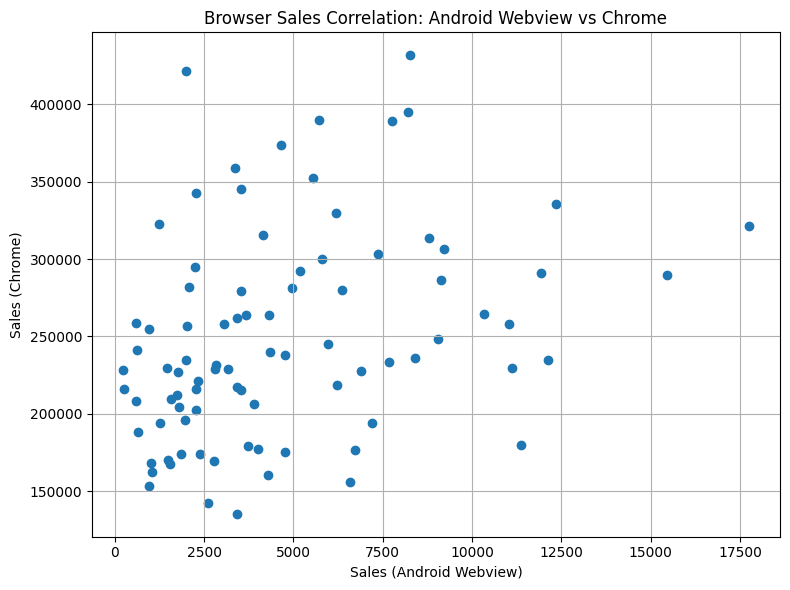

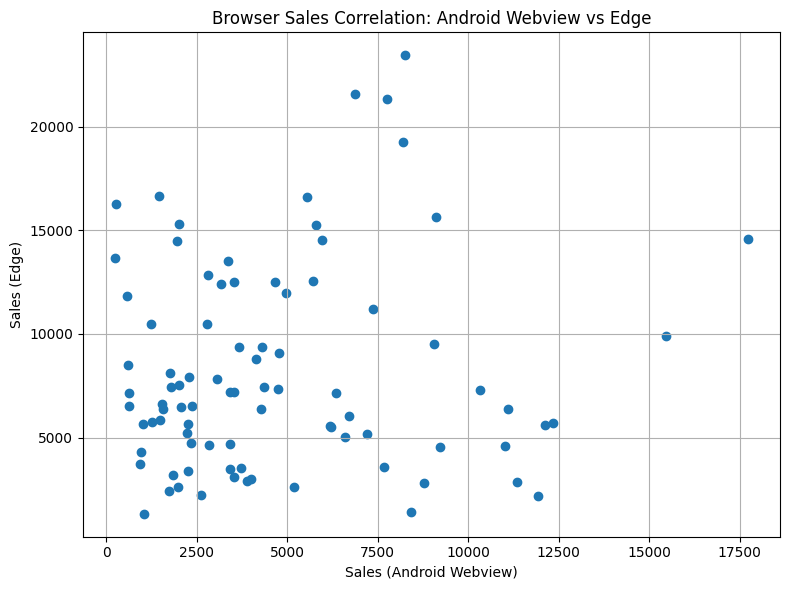

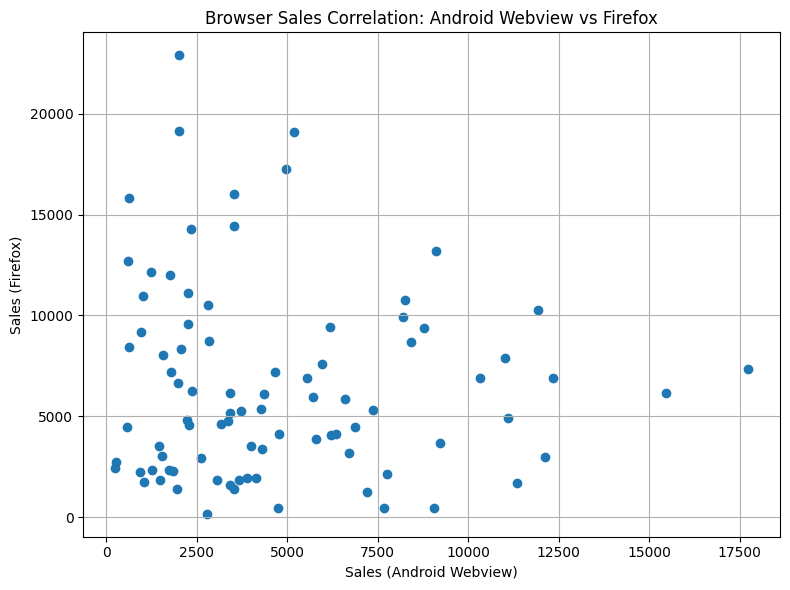

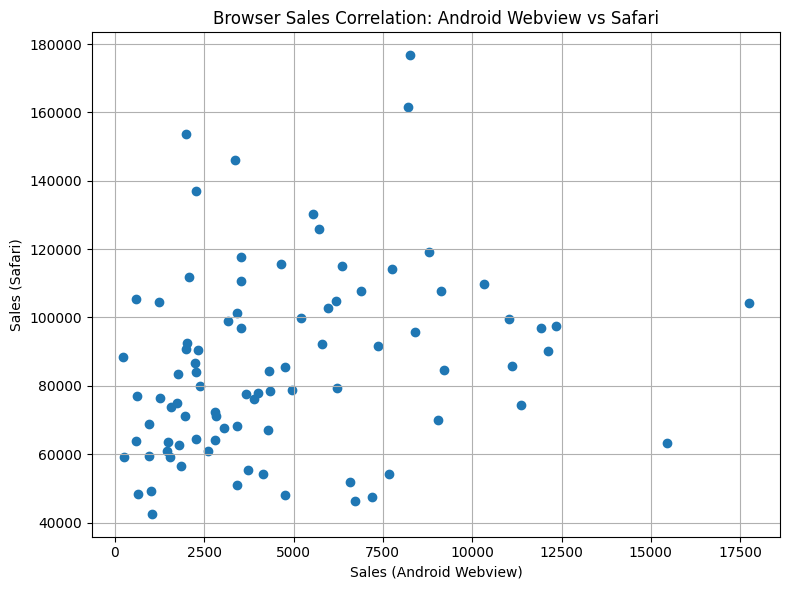

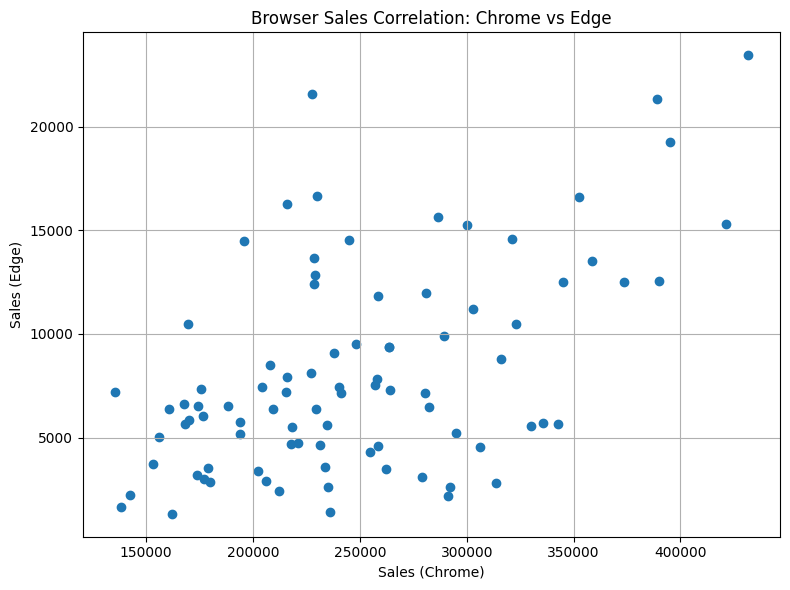

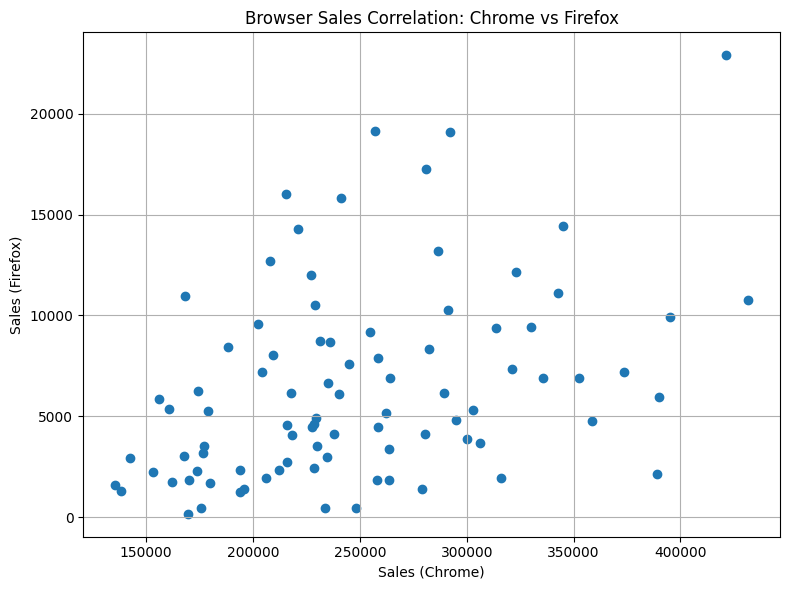

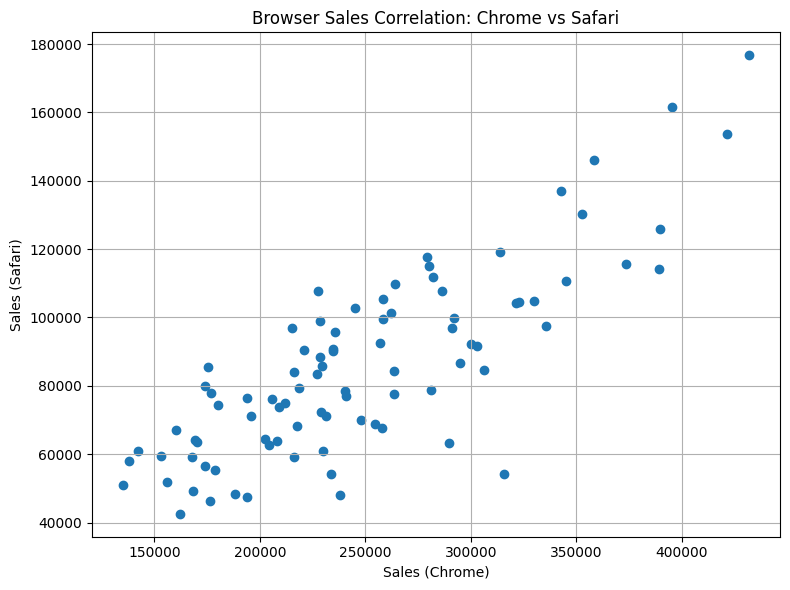

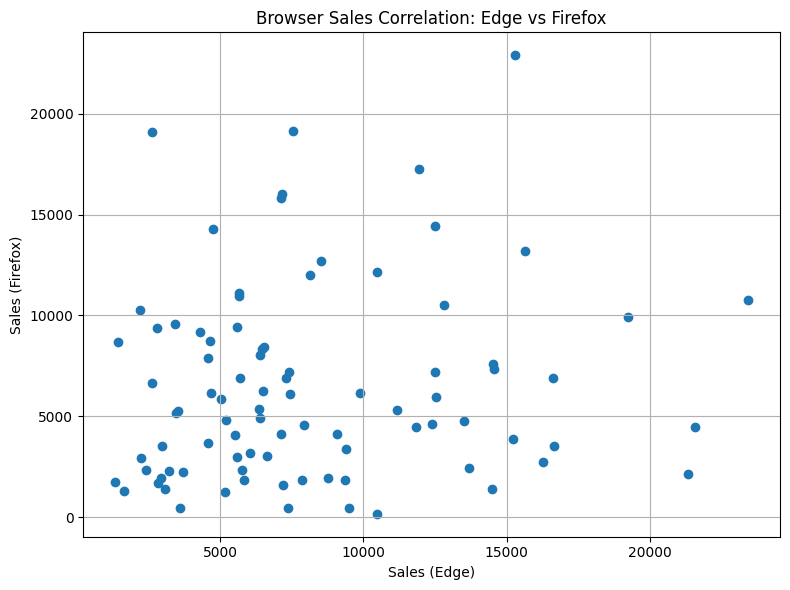

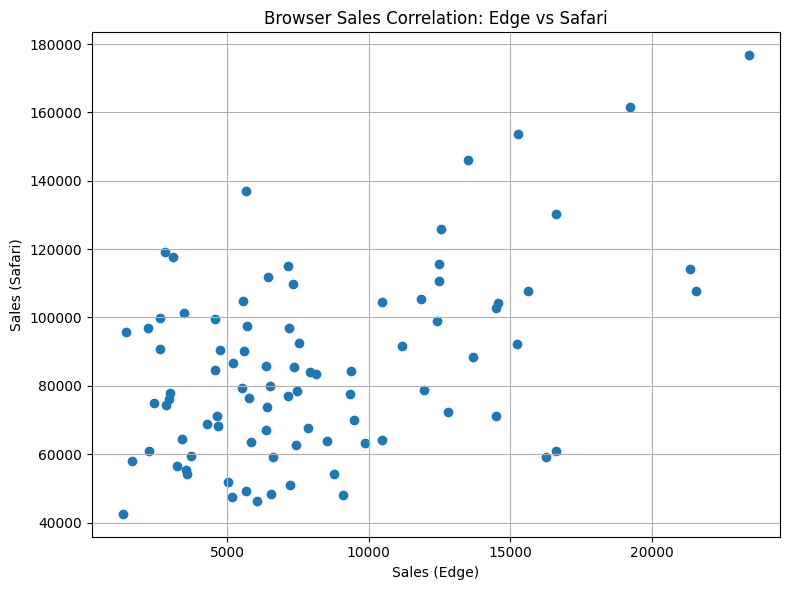

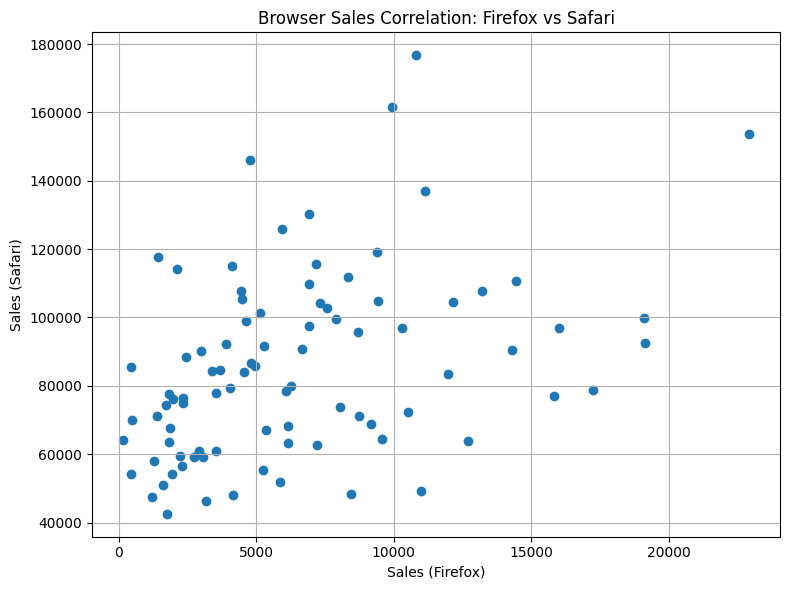

In [ ]:
def create_scatter_plots(data, title_prefix, x_label, y_label):
    columns = data.columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1 = columns[i]
            col2 = columns[j]
            plt.figure(figsize=(8, 6))
            plt.scatter(data[col1], data[col2])
            plt.xlabel(x_label + f" ({col1})")
            plt.ylabel(y_label + f" ({col2})")
            plt.title(f"{title_prefix}: {col1} vs {col2}")
            plt.grid(True)
            plt.tight_layout()
            plt.show()

create_scatter_plots(browser_sales, "Browser Sales Correlation", "Sales", "Sales")

###7. Статистичний аналіз відмінностей між групами.

Аналіз продажів за кожну дату зареєстрованих та незареєстрованих користувачів. Створення відповідних вибірок, аналіз розподілі даних в обох вибірках. Підбор відповідного статистичного тесту для порівняння вибірок. Висновок щодо статистичної значущості отриманих результатів.




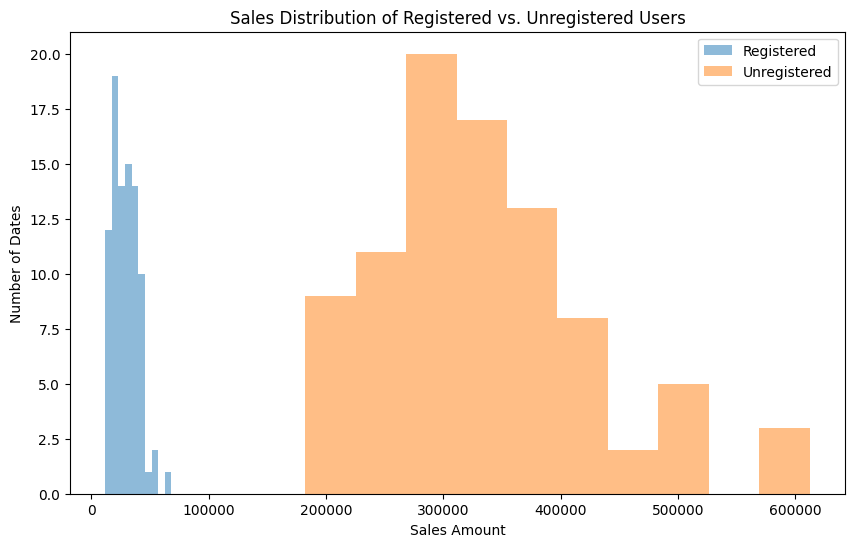

Shapiro-Wilk test for registered: ShapiroResult(statistic=0.9591810175035426, pvalue=0.007295139880540744)
Shapiro-Wilk test for unregistered: ShapiroResult(statistic=0.9521579282190968, pvalue=0.0026183359245325936)
Mann-Whitney U test used
P-value: 2.2159276950123465e-30
There are statistically significant differences between sales of registered and unregistered users.


In [ ]:
registered_sales = df_orders[df_orders['registrated_id'].notna()].groupby('order_date')['product_price'].sum()
unregistered_sales = df_orders[df_orders['registrated_id'].isna()].groupby('order_date')['product_price'].sum()

if registered_sales.empty or registered_sales.dropna().empty:
    print("No sales data for registered users.")
    if unregistered_sales.empty or unregistered_sales.dropna().empty:
        print("No sales data for unregistered users. Analysis is impossible.")
    else:
        print("Difference analysis is impossible as there is data only for unregistered users.")
    exit()
elif unregistered_sales.empty or unregistered_sales.dropna().empty:
    print("No sales data for unregistered users. Difference analysis is impossible.")
    exit()

plt.figure(figsize=(10, 6))

if not registered_sales.dropna().empty:
    plt.hist(registered_sales.dropna(), alpha=0.5, label='Registered')
if not unregistered_sales.dropna().empty:
    plt.hist(unregistered_sales.dropna(), alpha=0.5, label='Unregistered')

plt.legend(loc='upper right')
plt.title('Sales Distribution of Registered vs. Unregistered Users')
plt.xlabel('Sales Amount')
plt.ylabel('Number of Dates')
plt.show()

shapiro_registered = stats.shapiro(registered_sales.dropna())
shapiro_unregistered = stats.shapiro(unregistered_sales.dropna())
print(f"Shapiro-Wilk test for registered: {shapiro_registered}")
print(f"Shapiro-Wilk test for unregistered: {shapiro_unregistered}")

if shapiro_registered.pvalue > 0.05 and shapiro_unregistered.pvalue > 0.05:

    levene_statistic, levene_p_value = stats.levene(registered_sales.dropna(), unregistered_sales.dropna())
    print(f"Levene's test for equal variances: p-value = {levene_p_value}")
    if levene_p_value > 0.05:
        equal_var = True
        print("Variances are considered equal. Using standard t-test.")
    else:
        equal_var = False
        print("Variances are considered unequal. Using Welch's t-test.")
    t_statistic, p_value = stats.ttest_ind(registered_sales.dropna(), unregistered_sales.dropna(), equal_var=equal_var)
    print("Student's t-test used")
elif len(registered_sales.dropna()) > 20 and len(unregistered_sales.dropna()) > 20: #if samples are big enough, we can use Mann-Whitney U test even if distibution is not normal

    statistic, p_value = stats.mannwhitneyu(registered_sales.dropna(), unregistered_sales.dropna())
    print("Mann-Whitney U test used")
else:
    print("Samples are too small for correct statistical testing.")
    exit()

print(f"P-value: {p_value}")
if p_value < 0.05:
    print("There are statistically significant differences between sales of registered and unregistered users.")
else:
    print("No statistically significant differences were found between sales of registered and unregistered users.")

Для перевірки нормальності розподілу використовуєм тест Shapiro-Wilk. Розподіли продажів як зареєстрованих, так і незареєстрованих користувачів статистично значуще відрізняються від нормального. Для порівняння двох незалежних вибірок (продажі зареєстрованих та незареєстрованих користувачів) обираємо U-критерій Манна-Уітні. Аналіз показав, що існують статистично значущі відмінності між обсягами продажів, здійснених зареєстрованими та незареєстрованими користувачами.

Аналіз кількості сесій за різними каналами трафіку.Підбор відповідного статистичного тесту. Висновок щодо статистичної значущості отриманих результатів.

In [ ]:
channel_sessions = df_filled.groupby('channel')['session_id'].count()

print("Session count per traffic channel:")
print(channel_sessions)

num_channels = len(channel_sessions)
print(f"\nNumber of traffic channels: {num_channels}")

if num_channels > 2:
    chi2_statistic, p_value = stats.chisquare(channel_sessions)
    print("\nChi-square test used")
    print(f"Chi-square statistic: {chi2_statistic}")
    print(f"P-value: {p_value}")

    if p_value < 0.05:
        print("There are statistically significant differences in session count between different traffic channels. The distribution is not uniform.")
    else:
        print("No statistically significant differences in session count between different traffic channels were found. The distribution can be considered uniform.")

elif num_channels == 2:

    total_sessions = channel_sessions.sum()
    prop1 = channel_sessions.iloc[0] / total_sessions
    prop2 = channel_sessions.iloc[1] / total_sessions


    counts = [channel_sessions.iloc[0], channel_sessions.iloc[1]]
    nobs = [total_sessions, total_sessions]
    z_statistic, p_value = proportions_ztest(counts, nobs)

    print("\nZ-test for proportions used")
    print(f"Z-statistic: {z_statistic}")
    print(f"P-value: {p_value}")

    if p_value < 0.05 :
        print("There are statistically significant differences between the proportions of sessions for the two channels.")
    else:
        print("No statistically significant differences between the proportions of sessions for the two channels were found.")

elif num_channels == 1:
    print("Only one traffic channel. Statistical analysis is not possible.")
else:
    print("No data on traffic channels. Analysis is not possible.")

Session count per traffic channel:
channel
Direct             81382
Organic Search    124425
Paid Search        94341
Social Search      27914
Undefined          21483
Name: session_id, dtype: Int64

Number of traffic channels: 5

Chi-square test used
Chi-square statistic: 111705.27557253001
P-value: 0.0
There are statistically significant differences in session count between different traffic channels. The distribution is not uniform.


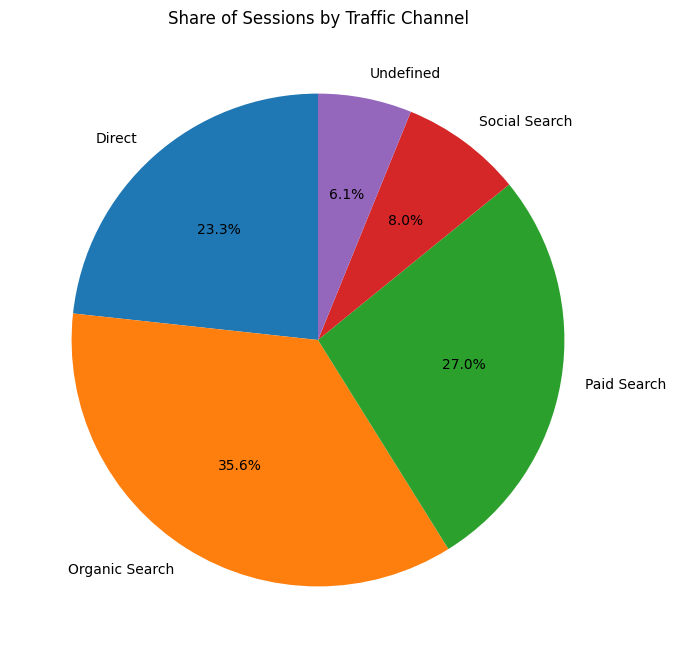

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(channel_sessions, labels=channel_sessions.index, autopct='%1.1f%%', startangle=90)
plt.title('Share of Sessions by Traffic Channel')
plt.show()

Кількість каналів трафіку становить 5, тому було обрано критерій χ² (хі-квадрат). Ми отримали результат: 111705.27557253001 – це значення статистики критерію χ². Чим більше це значення, тим більше відмінність між спостережуваним та очікуваним розподілами.
Аналіз показав, що існують статистично значущі відмінності в кількості сесій між різними каналами трафіку. Розподіл кількості сесій не є рівномірним. Деякі канали (наприклад, Organic Search та Paid Search) показують значно більше сесій, ніж інші (наприклад, Social Search та Undefined).

Чи відрізняється статистично доля сесій з органічним трафіком у Європі та Америці? Підбери відповідний тест. Проведи потрібні обчислення для створення вхідних даних до тесту

In [ ]:
organic_europe = df_filled[(df_filled['continent'] == 'Europe') & (df_filled['channel'] == 'Organic Search')]['session_id'].count()
total_europe = df_filled[df_filled['continent'] == 'Europe']['session_id'].count()

organic_americas = df_filled[(df_filled['continent'] == 'Americas') & (df_filled['channel'] == 'Organic Search')]['session_id'].count()
total_americas = df_filled[df_filled['continent'] == 'Americas']['session_id'].count()

print(f"Organic sessions in Europe: {organic_europe}")
print(f"Total sessions in Europe: {total_europe}")
print(f"Organic sessions in Americas: {organic_americas}")
print(f"Total sessions in Americas: {total_americas}")

if total_europe == 0 and total_americas == 0:
    print("No sessions data available for both Europe and Americas. Cannot perform analysis.")
elif total_europe == 0:
    print("No sessions data available for Europe. Cannot compare proportions.")
elif total_americas == 0:
    print("No sessions data available for Americas. Cannot compare proportions.")
else:


    count = [organic_europe, organic_americas]
    nobs = [total_europe, total_americas]


    stat, pval = proportions_ztest(count, nobs)

    print("\nZ-test for proportions used")
    print(f"Z-statistic: {stat}")
    print(f"P-value: {pval}")

    if pval < 0.05:
        print("There are statistically significant differences in the proportion of organic traffic between Europe and Americas.")
    else:
        print("No statistically significant differences were found in the proportion of organic traffic between Europe and Americas.")

Organic sessions in Europe: 23195
Total sessions in Europe: 65135
Organic sessions in Americas: 68671
Total sessions in Americas: 193179

Z-test for proportions used
Z-statistic: 0.28951412926103953
P-value: 0.7721879690501752
No statistically significant differences were found in the proportion of organic traffic between Europe and Americas.


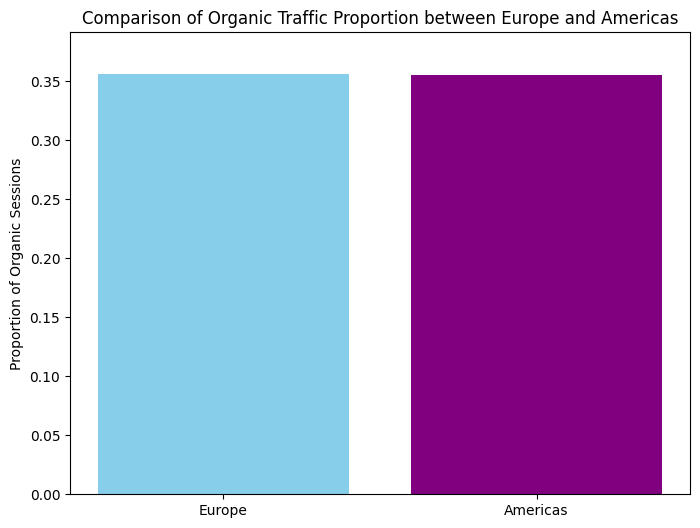

In [ ]:
    proportions = [organic_europe / total_europe, organic_americas / total_americas]
    continents = ['Europe', 'Americas']

    plt.figure(figsize=(8, 6))
    plt.bar(continents, proportions, color=['skyblue', 'purple'])
    plt.ylabel('Proportion of Organic Sessions')
    plt.title('Comparison of Organic Traffic Proportion between Europe and Americas')
    plt.ylim(0, max(proportions) * 1.1)
    plt.show()

Оскільки ми порівнюємо частки (пропорції) в двох незалежних групах (Європа та Америка), використовуємо z-тест для пропорцій. Статистично значущих відмінностей у частці сесій з органічним трафіком між Європою та Америкою немає. Хоча абсолютні значення кількості органічних сесій різні, їхня частка від загальної кількості сесій на кожному континенті статистично не відрізняється.

Проведення обчислення за допомогою ANOVA у кількості сесій між різними девайсами.

In [ ]:
if 'device' not in df_filled.columns:
    print("Error: 'device' column not found in the DataFrame.")
    exit()


unique_devices = df_filled['device'].unique()
device_groups = [df_filled[df_filled['device'] == device]['session_id'].values for device in unique_devices]

if any(len(group) == 0 for group in device_groups):
    print("Error: One or more device groups have no data. ANOVA cannot be performed.")
    exit()

f_statistic, p_value_anova = stats.f_oneway(*device_groups)

print("\nANOVA results:")
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value_anova}")

if p_value_anova < 0.05:
    print("\nThere are statistically significant differences in session count between different devices.")
else:
    print("\nNo statistically significant differences were found in session count between different devices.")


ANOVA results:
F-statistic: 0.21287204534314538
P-value: 0.8082596559933919

No statistically significant differences were found in session count between different devices.


Немає статистично значущих відмінностей у кількості сесій між різними девайсами. Це означає, що дані не підтверджують гіпотезу про те, що девайс суттєво впливає на кількість сесій.

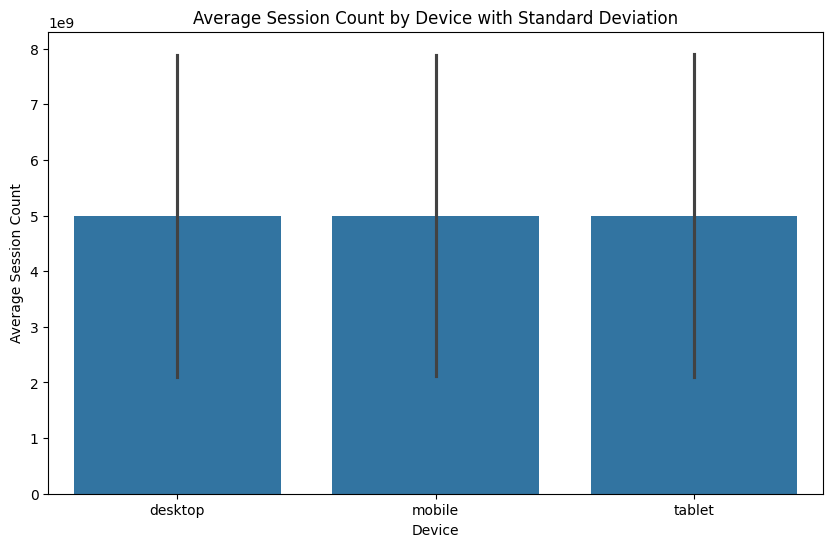

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='device', y='session_id', data=df_filled, errorbar='sd')
plt.title('Average Session Count by Device with Standard Deviation')
plt.xlabel('Device')
plt.ylabel('Average Session Count')
plt.show()

###8. Створення аналітичного дашборду у Tableau Public. Дашборд має містити не більше 2 сторінок.

###9. Етапи роботи та висновки:
Був створений Portfolio Project 2 за допомогою інструментів: SQL, Python, Tableau. Спочатку в SQL був створений запит з бази даних, у якому міститься інформація про необхідні показники. З BiqQuery я завантажила дані у Python та на основі їх зробила необхідні розрахунки.
Наступним кроком було підключити SQL запит до Tableau. Я створила новий дашборд Analytic and Dynamic. У дашборді містяться дані про аналітику та динаміку. Він має 2 сторінки, які перемикаються за допомогою навігації.

https://public.tableau.com/app/profile/olena.halkina6622/viz/AnalyticandDynamic/SessionDynamic?publish=yes


